<h1>Проект: Обучение с учителем: качество модели

**Описание проекта**

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 

Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Ход исследования:**
1. Загрузка и обзор данных.

2. Предобработка данных.

3. Исследовательский анализ данных.

4. Объединение таблиц.

5. Корреляционный анализ.

6. Использование пайплайнов.

7. Анализ важности признаков

8. Сегментация покупателей

9. Общий вывод

## Загрузка и обзор данных

In [1]:
!pip install phik

In [2]:
!pip install shap

In [3]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install optuna 

In [5]:
pip install optuna-integration[sklearn]

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.metrics import make_scorer, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.inspection import permutation_importance

import time

import phik
import shap
import warnings
from optuna.integration import OptunaSearchCV 
from optuna import distributions
from optuna.distributions import IntDistribution,CategoricalDistribution
import warnings
warnings.filterwarnings("ignore")

In [7]:
RANDOM_STATE=42
TEST_SIZE=0.25

In [8]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_file.sample(2)

id Покупательская активность Тип сервиса Разрешить сообщать  \
1210  216558           Прежний уровень     премиум                 да   
402   215750           Прежний уровень    стандарт                 да   

      Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
1210                 4.3                     4           684   
402                  4.8                     5           634   

      Акционные_покупки            Популярная_категория  \
1210               0.18  Техника для красоты и здоровья   
402                0.21                Товары для детей   

      Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
1210                                    1                                   6   
402                                     4                                   5   

      Ошибка_сервиса  Страниц_за_визит  
1210               1                 8  
402                3                10

In [9]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

**Вывод:**
- В датафрейме market_file 1300 строк без пропущенных значений в данных.
- Тип данных в столбцах соответствует содержанию. 

In [10]:
market_money = pd.read_csv('/datasets/market_money.csv')
market_money.sample(2)

id               Период  Выручка
3640  216561  препредыдущий_месяц   4430.0
960   215668        текущий_месяц   5293.2

In [11]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


**Вывод:**
- В датафрейме market_money 3900 строк без пропущенных значений в данных.
- Тип данных в столбцах соответствует содержанию. 
- Следует удалить нижний пробел в данных столбца Период.

In [12]:
market_time = pd.read_csv('/datasets/market_time.csv')
market_time.sample(2)

id            Период  минут
1612  216154     текущий_месяц     15
175   215435  предыдцщий_месяц      7

In [13]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


**Вывод:**
- В датафрейме market_time 2600 строк без пропущенных значений в данных.
- Тип данных в столбцах соответствует содержанию. 
- Следует удалить нижний пробел в данных столбца Период.

In [14]:
data_money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
data_money.sample(2)

id  Прибыль
1004  216352     5.27
500   215848     2.23

In [15]:
data_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


**Вывод:**
- В датафрейме data_money 1300 строк без пропущенных значений в данных.
- Тип данных в столбцах соответствует содержанию. 

**Вывод по разделу:**
1) В датафрейме market_file - 1300 строк, в market_money - 3900 строк, в market_time - 2600 строк, в data_money - 1300 строк.

2) Типы данных соответствуют содержанию во всех датафреймах.

## Предобработка данных

**2.1 Исправление стилистики в названиях столбцов**

In [16]:
def rename_column(df):
    df.columns = df.columns.str.replace(' ', '_').str.lower()
    return df.sample(1)

In [17]:
rename_column(market_file)

id покупательская_активность тип_сервиса разрешить_сообщать  \
639  215987           Прежний уровень     премиум                 да   

     маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
639                 3.3                     4           736   

     акционные_покупки   популярная_категория  \
639               0.23  Косметика и аксесуары   

     средний_просмотр_категорий_за_визит  неоплаченные_продукты_штук_квартал  \
639                                    2                                   4   

     ошибка_сервиса  страниц_за_визит  
639               5                12

In [18]:
rename_column(market_money)

id         период  выручка
1016  215686  текущий_месяц   4952.8

In [19]:
rename_column(market_time)

id            период  минут
955  215825  предыдцщий_месяц     17

In [20]:
rename_column(data_money)

id  прибыль
1091  216439     4.32

**2.2 Удаление нижних пробелов в данных датафреймов**

In [21]:
market_money.sample(1)

id         период  выручка
1820  215954  текущий_месяц   6518.4

In [22]:
market_money['период'] = market_money['период'].str.replace('_', ' ')
market_money.sample(1)

id               период  выручка
1515  215853  препредыдущий месяц   4865.0

In [23]:
market_time.sample(1)

id         период  минут
1513  216104  текущий_месяц     17

In [24]:
market_time['период'] = market_time['период'].str.replace('_', ' ')
market_time.sample(1)

id         период  минут
952  215824  текущий месяц     12

**2.3 Проверка наличия пропущенных значений.**

In [25]:
def data_isna(row):
    return row.isna().sum()

In [26]:
data_isna(market_file)

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

In [27]:
data_isna(market_money)

id         0
период     0
выручка    0
dtype: int64

In [28]:
data_isna(market_time)

id        0
период    0
минут     0
dtype: int64

In [29]:
data_isna(data_money)

id         0
прибыль    0
dtype: int64

**Вывод:**
    
Пропущенных значений в датафреймах не обнаружено.

**2.4 Проверка явных дубликатов в датафреймах.**

In [30]:
def duplacates_sum(df):
    return df.duplicated().sum()

In [31]:
duplacates_sum(market_file)

0

In [32]:
duplacates_sum(market_money)

0

In [33]:
duplacates_sum(market_time)

0

In [34]:
duplacates_sum(data_money)

0

**Вывод:**
    
Явных дубликатов в датафреймах не обнаружено.

**2.5 Устранение неявных дубликатов в датафреймах.**

In [35]:
def replace_dubl(df,column,old_name,new_name):
    df[column] = df[column].replace(old_name,new_name)
    return df[column].unique()

In [36]:
market_file['тип_сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [37]:
replace_dubl(market_file, 'тип_сервиса','стандартт', 'стандарт')

array(['премиум', 'стандарт'], dtype=object)

In [38]:
market_time['период'].unique()

array(['текущий месяц', 'предыдцщий месяц'], dtype=object)

In [39]:
replace_dubl(market_time, 'период','предыдцщий месяц', 'предыдущий месяц')

array(['текущий месяц', 'предыдущий месяц'], dtype=object)

In [40]:
market_file['популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [41]:
replace_dubl(market_file, 'популярная_категория','Косметика и аксесуары', 'Косметика и аксессуары')

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксессуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

**Вывод по разделу:**

1) Была исправлена стилистика в названиях столбцов. Названия были переведены в нижний регистр.

2) В данных датафреймов был удален нижний пробел между словами.

3) Пропущенных значений не было обнаружено.

4) Явных дубликатов не было обнаружено.

5) В датафреймах market_file и market_time были устранены неявные дубликаты.

## Исследовательский анализ данных

**3.1 Исследовательский анализ датафрейма market_file.**

**3.1.1 Исследовательский анализ покупательской активности.**

In [42]:
def search_plot(df, column1, column2):
    plot = sns.histplot(data=df,x=column1, hue=column2)
    plt.show()

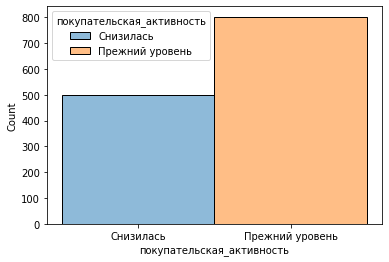

In [43]:
search_plot(market_file,'покупательская_активность', 'покупательская_активность')

**Вывод:**

Из графика видно, что у целевого признака присутствует дисбаланс данных в классах.

**3.1.2 Исследовательский анализ типа сервиса.**

In [44]:
def sns_hist(df, column_x, column_hue):
    sns.histplot(data=df, x=column_x, hue=column_hue, bins=20, kde=True).set_title(f'Гистограмма {column_x}')
    plt.xticks(rotation=90)
    
    plt.show()

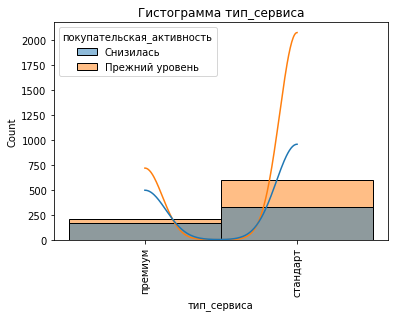

In [45]:
sns_hist(market_file,'тип_сервиса','покупательская_активность')

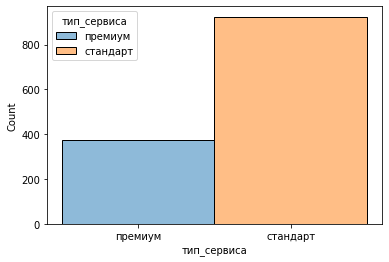

In [46]:
search_plot(market_file,'тип_сервиса', 'тип_сервиса')

**Вывод:**

Из графика видно, что тип сервиса "стандарт" преобладает над типом сервиса "премиум" и что покупатели с прежним уровнем активности предпочитают тип сервиса - стандарт.

**3.1.3 Исследовательский анализ разрешения присылать информацию.**

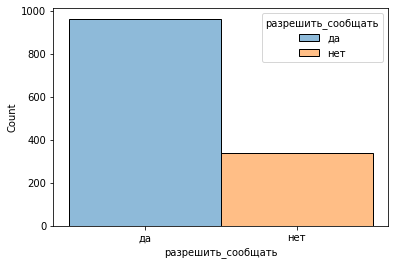

In [47]:
search_plot(market_file,'разрешить_сообщать', 'разрешить_сообщать')

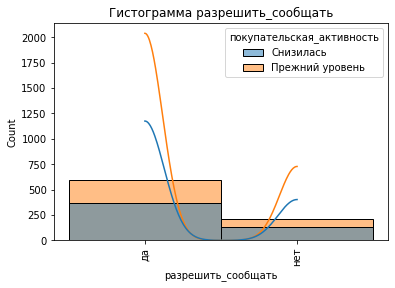

In [48]:
sns_hist(market_file,'разрешить_сообщать','покупательская_активность')

**Вывод:**

Из графика видно, что покупатели чаще разрешают присылать им информацию, чем не разрешают. Покупатели с прежним уровнем активности и покупатели со снизившимся уровнем активности разрешают присылать им информацию.

**3.1.4 Исследовательский анализ маркетинговой активности за 6 месяцев.**

In [49]:
market_file[market_file['маркет_актив_6_мес']<1]

id покупательская_активность тип_сервиса разрешить_сообщать  \
81    215429                 Снизилась     премиум                нет   
147   215495                 Снизилась    стандарт                 да   
164   215512                 Снизилась    стандарт                 да   
204   215552                 Снизилась    стандарт                 да   
205   215553                 Снизилась    стандарт                 да   
253   215601                 Снизилась     премиум                 да   
269   215617                 Снизилась    стандарт                 да   
353   215701                 Снизилась    стандарт                 да   
357   215705                 Снизилась     премиум                нет   
389   215737                 Снизилась    стандарт                 да   
1287  216635           Прежний уровень    стандарт                 да   

      маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
81                   0.9                     4           690   
147                  0.9                     4           788   
164                  0.9                     3           839   
204                  0.9                     4           624   
205                  0.9                     4           360   
253                  0.9                     4           468   
269                  0.9                     4           728   
353                  0.9                     4           212   
357                  0.9                     4           657   
389                  0.9                     4           225   
1287                 0.9                     3           932   

      акционные_покупки            популярная_категория  \
81                 0.24               Домашний текстиль   
147                0.98  Техника для красоты и здоровья   
164                0.40          Косметика и аксессуары   
204                0.89          Косметика и аксессуары   
205                0.33               Домашний текстиль   
253                0.23  Техника для красоты и здоровья   
269                0.90               Домашний текстиль   
353                0.95               Домашний текстиль   
357                0.99               Домашний текстиль   
389                0.36          Косметика и аксессуары   
1287               0.35          Косметика и аксессуары   

      средний_просмотр_категорий_за_визит  неоплаченные_продукты_штук_квартал  \
81                                      2                                   5   
147                                     3                                   3   
164                                     3                                   3   
204                                     1                                   9   
205                                     2                                   3   
253                                     1                                   6   
269                                     2                                   3   
353                                     2                                   5   
357                                     2                                   4   
389                                     2                                   4   
1287                                    3                                   3   

      ошибка_сервиса  страниц_за_визит  
81                 7                 4  
147                3                 3  
164                7                 7  
204                5                 1  
205                3                 5  
253                4                 4  
269                2                 4  
353                4                 2  
357                2                 5  
389                2                 3  
1287               8                 5

In [50]:
market_file['маркет_актив_6_мес'].describe()

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64

In [51]:
def sns_hist_box(df, column_x, column_hue):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    
    sns.histplot(data=df, x=column_x, hue=column_hue, bins=20, kde=True, ax=ax1)
    ax1.set_title(f'Гистограмма {column_x}')
    
    sns.boxplot(data=df, x=column_hue, y=column_x, ax=ax2)
    ax2.set_title(f'Boxplot {column_x}')
    
    plt.show()

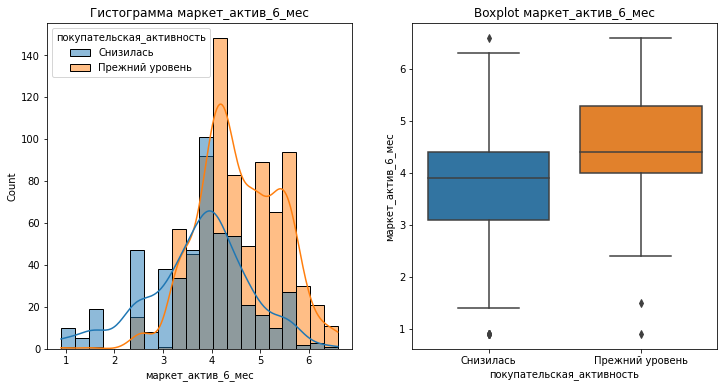

In [52]:
sns_hist_box(market_file, 'маркет_актив_6_мес', 'покупательская_активность')

**Вывод:**

Из графика видно, что средняя маркетинговая активность за 6 месяцев - 4,2. Минимальное значение - 0,9 не является выбросом. Высокая маркетинговая активность за 6 месяцев в основном у покупателей с прежним уровнем активности.

**3.1.5 Исследовательский анализ маркетинговой активности за текущий месяц.**

In [53]:
market_file['маркет_актив_тек_мес'].describe()

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64

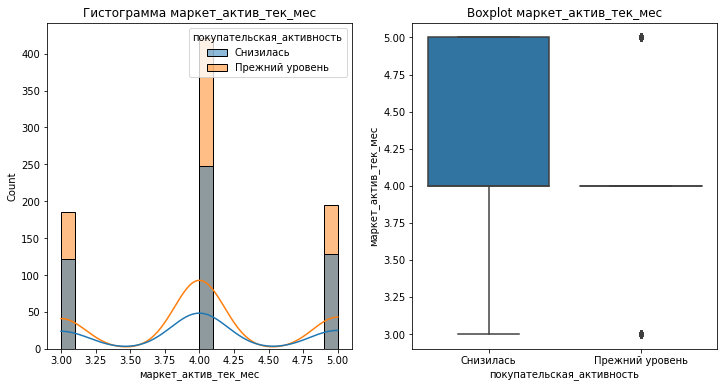

In [54]:
sns_hist_box(market_file, 'маркет_актив_тек_мес', 'покупательская_активность')

**Вывод:**

Из графика видно, что средняя маркетинговая активность за текущий месяцев - 4,0.

**3.1.6 Исследовательский анализ длительности.**

In [55]:
market_file['длительность'].describe()

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64

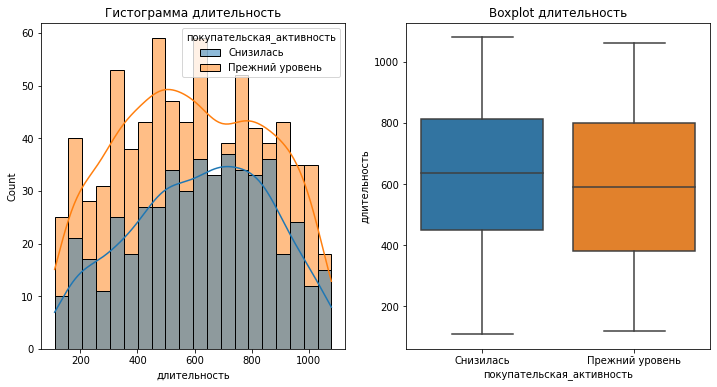

In [56]:
sns_hist_box(market_file, 'длительность', 'покупательская_активность')

**Вывод:**

Из графика видно, что в среднем проходит 600 дней с момента регистрации покупателя на сайте. Большая длительность у покупателей со снизившимся уровнем активности.

**3.1.7 Исследовательский анализ акционных покупок.**

In [57]:
market_file['акционные_покупки'].describe()

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64

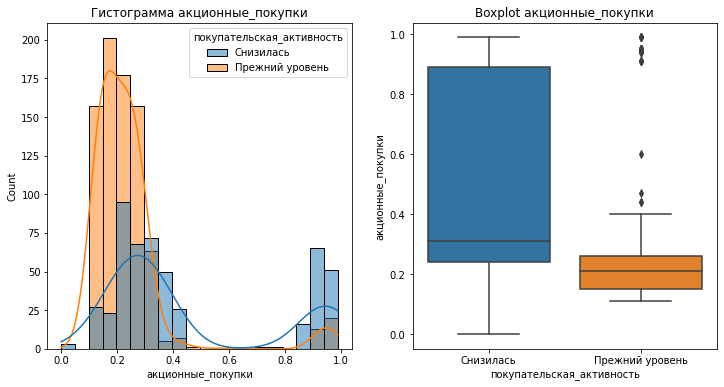

In [58]:
sns_hist_box(market_file, 'акционные_покупки', 'покупательская_активность')

**Вывод:**

Из графика видно, что в среднем покупатели не отслеживают акционные товары. При корреляционном анализе необходимо выявить границу между покупкой по акции и отсутствием покупки по акции.

Акционные товары приобретают покупатели со снизившимся уровнем активности.

**3.1.8 Исследовательский анализ популярной категории.**

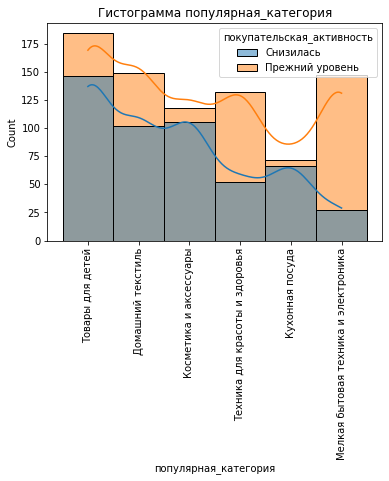

In [59]:
sns_hist(market_file, 'популярная_категория', 'покупательская_активность')

**Вывод:**

Из графика видно, что самой популярной категорией является - Товары для детей.

**3.1.9 Исследовательский анализ просмотра категорий за визит.**

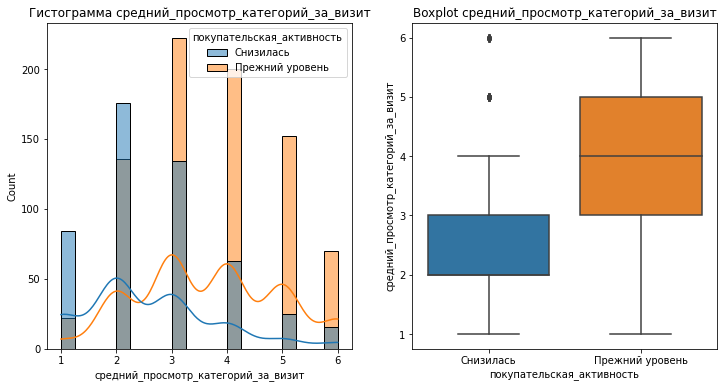

In [60]:
sns_hist_box(market_file, 'средний_просмотр_категорий_за_визит', 'покупательская_активность')

**Вывод:**

Из графика видно, что в среднем просматривается 3 категории за визит. Покупатели с прежним уровнем активности просматривают 4 категории за визит, а покупатели со снизившейся активностью - 2-3 категории.

**3.1.10 Исследовательский анализ неоплаченных продуктов.**

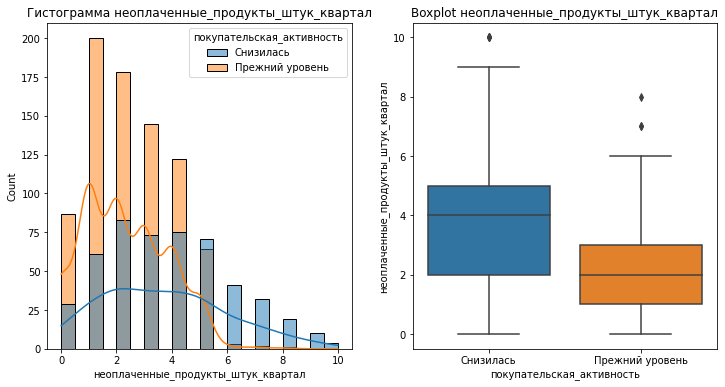

In [61]:
sns_hist_box(market_file, 'неоплаченные_продукты_штук_квартал', 'покупательская_активность')

**Вывод:**

Из графика видно, что в среднем общее число неоплаченных товаров в корзине за последние 3 месяца - 1 или 2 товара. Покупатели с прежним уровнем активности не оплачивают 2 товара в корзине, а покупатели со снизившейся активностью - 4 товара.

**3.1.11 Исследовательский анализ ошибок сервиса.**

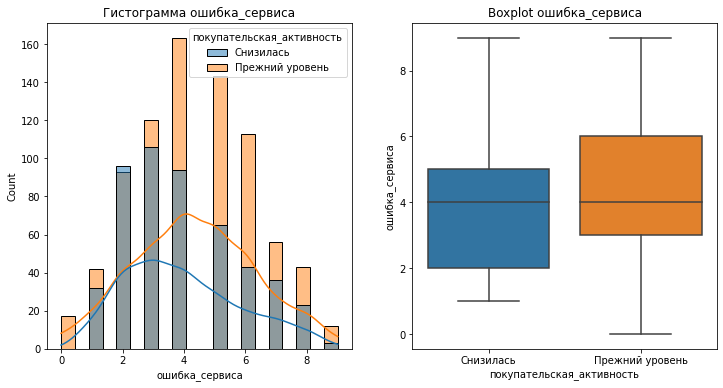

In [62]:
sns_hist_box(market_file, 'ошибка_сервиса', 'покупательская_активность')

**Вывод:**

Из графика видно, что в среднем происходит 4 сбоя во время посещения сайта. У покупателей с прежним уровнем активности в среднем 4 сбоя как и у покупателей со снизившейся активностью.

**3.1.12 Исследовательский анализ страниц за визит.**

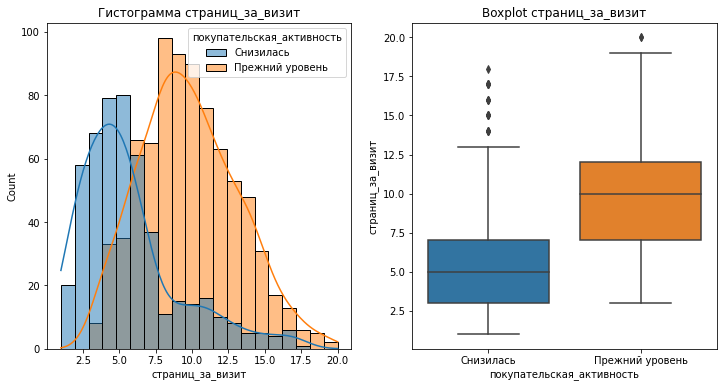

In [63]:
sns_hist_box(market_file, 'страниц_за_визит', 'покупательская_активность')

In [64]:
market_file['страниц_за_визит'].describe()

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64

**Вывод:**

Из графика видно, что среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца - 8 страниц. У покупателей с прежним уровнем активности 10 просмотренных страниц за визит, а у покупателей со снизившейся активностью - 5 страниц.

**3.2 Исследовательский анализ датафрейма market_money.**

**3.2.1 Исследовательский анализ периода.**

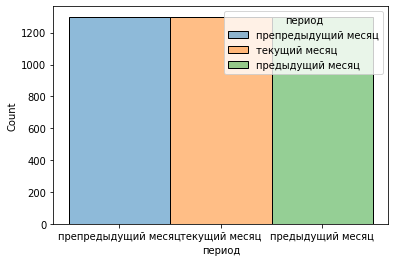

In [65]:
search_plot(market_money,'период', 'период')

**Вывод:**

Из графика видно, что выручка зафиксирована у одинакового количества клиентов за разный период.

**3.2.2 Исследовательский анализ выручки в зависимости от периода.**

In [66]:
def sns_hist_box_period(df, column_x, column_hue):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    
    sns.histplot(data=df, x=column_x, hue=column_hue, bins=20, kde=True, ax=ax1)
    ax1.set_title(f'Гистограмма {column_x}')
    
    sns.boxplot(data=df, x=column_hue, y=column_x, ax=ax2)
    ax2.set_title(f'Boxplot {column_x}')
    plt.xticks(rotation=90)
    
    plt.show()

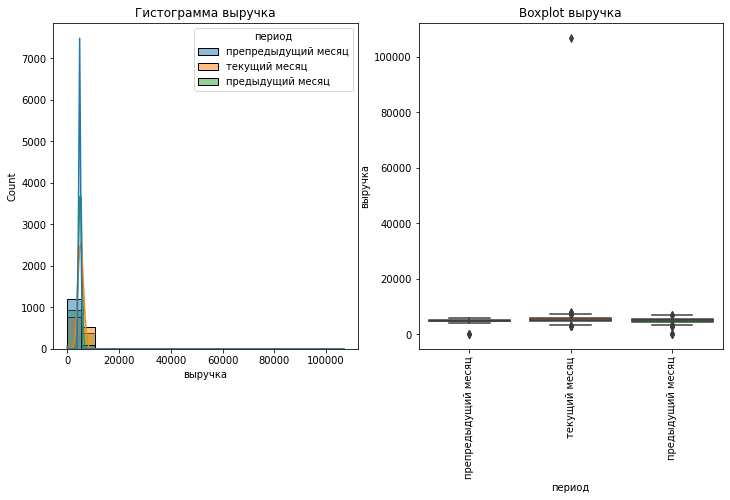

In [67]:
sns_hist_box_period(market_money, 'выручка', 'период')

В данных о выручке есть выброс.Удалим его.

In [68]:
market_money[market_money['выручка']>100000]

id         период   выручка
98  215380  текущий месяц  106862.2

In [69]:
market_money[market_money['выручка']<1]

id               период  выручка
0   215348  препредыдущий месяц      0.0
2   215348     предыдущий месяц      0.0
28  215357  препредыдущий месяц      0.0
29  215357     предыдущий месяц      0.0
34  215359     предыдущий месяц      0.0
35  215359  препредыдущий месяц      0.0

Так как по ТЗ нам нужны покупатели с активностью за все 3 месяца, то данные с нулевой выручкой нужно удалить.

In [70]:
market_money = market_money[(market_money['выручка']<100000) & (market_money['выручка']>1)]

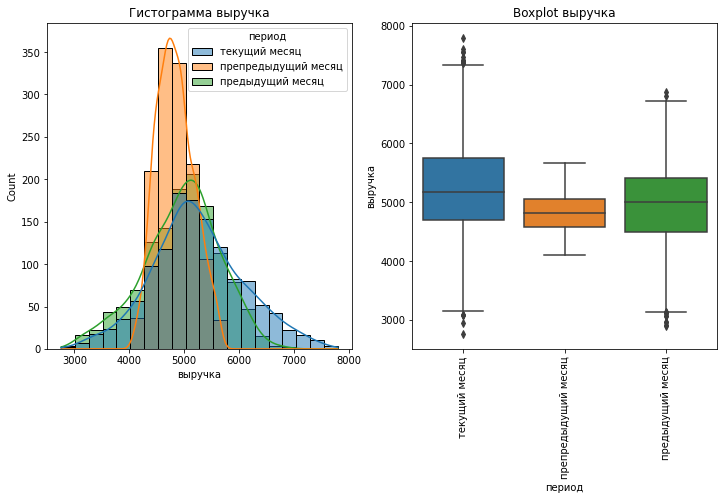

In [71]:
sns_hist_box_period(market_money, 'выручка', 'период')

In [72]:
def pivot_sign(df,column1,column2,column3,func):
    row = df.pivot_table(index=column1,values=column2,aggfunc=func)
    return row.sort_values(by=column3,ascending=False)

In [73]:
revenue_period = pivot_sign(market_money, 'период', 'выручка', 'выручка', 'sum')

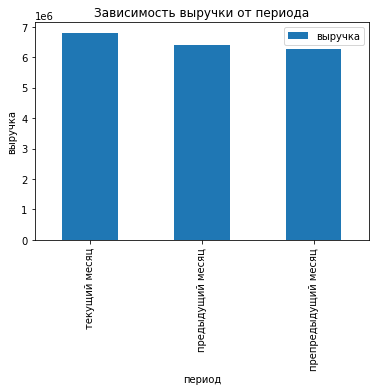

In [74]:
revenue_period.plot(kind='bar')
plt.xlabel('период')
plt.ylabel('выручка')
plt.title('Зависимость выручки от периода')
plt.show()

**Вывод:**

Из графика видно, что выручка у текущего периода больше, чем у предыдущего и препредыдущего периода.

**3.3 Исследовательский анализ датафрейма market_time.**

**3.3.1 Исследовательский анализ периода.**

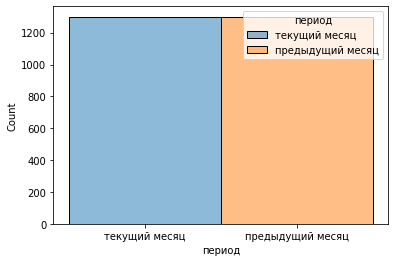

In [75]:
search_plot(market_time,'период', 'период')

**Вывод:**

Из графика видно, что время зафиксированное в определённый период получено от одинакового количества пользователей.

**3.3.2 Исследовательский анализ ко-ва минут в зависимости от периода.**

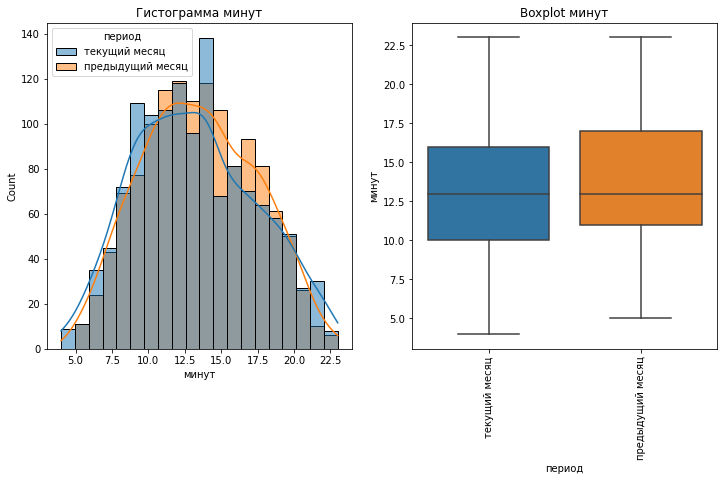

In [76]:
sns_hist_box_period(market_time, 'минут', 'период')

Выбросов не видно.

In [77]:
minutes_period = pivot_sign(market_time, 'период', 'минут', 'минут', 'sum')
minutes_period

минут
период                 
предыдущий месяц  17508
текущий месяц     17166

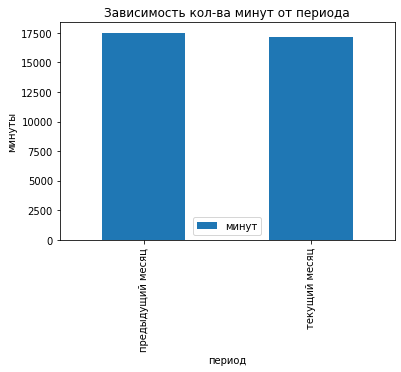

In [78]:
minutes_period.plot(kind='bar')
plt.xlabel('период')
plt.ylabel('минуты')
plt.title('Зависимость кол-ва минут от периода')
plt.show()

**Вывод:**

Из графика видно, что клиенты проводили время на сайте одинаковое количество времени и в текущем месяце и в предыдущем месяце.

**3.4 Исследовательский анализ датафрейма data_money.**

In [79]:
def research_box_hist(column, df):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})    
    
    sns.boxplot(x=df[column], orient="h", ax=ax_box)
    sns.histplot(data=df, x=column, ax=ax_hist)

    ax_box.set(xlabel='')
    plt.show()

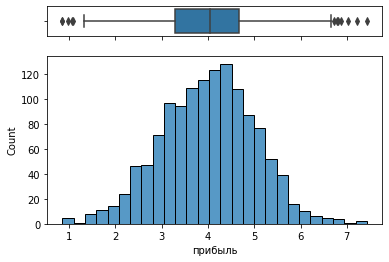

In [80]:
research_box_hist('прибыль', data_money)

In [81]:
data_money['прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

**Вывод:**

Из графика видно, что в среднем значение прибыли равно 4.

**3.5 Отбор клиентов с покупательской активностью не менее трёх месяцев.**

In [82]:
count_period = market_money.groupby('id').agg({'период': 'count'}).reset_index()
active_filter = count_period[count_period['период'] ==3]
active_filter

id  период
1     215349       3
2     215350       3
3     215351       3
4     215352       3
5     215353       3
...      ...     ...
1295  216643       3
1296  216644       3
1297  216645       3
1298  216646       3
1299  216647       3

[1296 rows x 2 columns]

In [83]:
market_file = market_file[market_file['id'].isin(active_filter['id'])]

In [84]:
market_money = market_money[market_money['id'].isin(active_filter['id'])]

In [85]:
market_time = market_time[market_time['id'].isin(active_filter['id'])]

**Вывод:**

Были отобраны 1296 покупателей с активностью не менее 3 месяцев. 

**Вывод по разделу:**

*Исследовательский анализ датафрейма market_file*

- у целевого признака присутствует дисбаланс данных в классах.

- nип сервиса "стандарт" преобладает над типом сервиса "премиум" и что покупатели с прежним уровнем активности предпочитают тип сервиса - стандарт.

- покупатели чаще разрешают присылать им информацию, чем не разрешают. Покупатели с прежним уровнем активности и покупатели со снизившимся уровнем активности разрешают присылать им информацию.

- средняя маркетинговая активность за 6 месяцев - 4,2. Минимальное значение - 0,9 не является выбросом. Высокая маркетинговая активность за 6 месяцев в основном у покупателей с прежним уровнем активности.

- средняя маркетинговая активность за текущий месяцев - 4,0. 

- в среднем проходит 600 дней с момента регистрации покупателя на сайте. Большая длительность у покупателей со снизившимся уровнем активности.

- в среднем покупатели не отслеживают акционные товары. При корреляционном анализе необходимо выявить границу между покупкой по акции и отсутствием покупки по акции.

- акционные товары приобретают покупатели со снизившимся уровнем активности.


- самой популярной категорией является - Товары для детей.

- в среднем просматривается 3 категории за визит. Покупатели с прежним уровнем активности просматривают 4 категории за визит, а покупатели со снизившейся активностью - 2-3 категории.

- в среднем общее число неоплаченных товаров в корзине за последние 3 месяца - 1 или 2 товара. Покупатели с прежним уровнем активности не оплачивают 2 товара в корзине, а покупатели со снизившейся активностью - 4 товара.

- в среднем происходит 4 сбоя во время посещения сайта. У покупателей с прежним уровнем активности в среднем 4 сбоя как и у покупателей со снизившейся активностью.

- среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца - 8 страниц. У покупателей с прежним уровнем активности 10 просмотренных страниц за визит, а у покупателей со снизившейся активностью - 5 страниц
 
*Исследовательский анализ датафрейма market_money.*

 - выручка зафиксирована у одинакового количества клиентов за разный период.
 
 - выручка у текущего периода больше, чем у предыдущего и препредыдущего периода.

*Исследовательский анализ датафрейма market_time.*

 - время зафиксированное в определённый период получено от одинакового количества пользователей.

 - клиенты проводили время на сайте одинаковое количество времени и в текущем месяце и в предыдущем месяце.

*Исследовательский анализ датафрейма data_money.*

 - в среднем значение прибыли равно 4.

*Отбор клиентов с покупательской активностью не менее трёх месяцев.*

 - Были отобраны 1296 покупателей с активностью не менее 3 месяцев. 

## Объединение таблиц

In [86]:
group_market_money = market_money.pivot_table(index='id', columns='период')
group_market_money.columns = ['выручка_пред_месяц', 'выручка_препред_месяц', 'выручка_тек_месяц']
group_market_money

выручка_пред_месяц  выручка_препред_месяц  выручка_тек_месяц
id                                                                  
215349              5216.0                 4472.0             4971.6
215350              5457.5                 4826.0             5058.4
215351              6158.0                 4793.0             6610.4
215352              5807.5                 4594.0             5872.5
215353              4738.5                 5124.0             5388.5
...                    ...                    ...                ...
216643              3664.0                 4704.0             4741.7
216644              4729.0                 5299.0             5353.0
216645              5160.0                 5334.0             5139.2
216646              4923.0                 4725.0             5224.6
216647              4720.0                 5183.0             4448.3

[1296 rows x 3 columns]

In [87]:
market = market_file.join(group_market_money, on='id')
market

id покупательская_активность тип_сервиса разрешить_сообщать  \
1     215349                 Снизилась     премиум                 да   
2     215350                 Снизилась    стандарт                нет   
3     215351                 Снизилась    стандарт                 да   
4     215352                 Снизилась    стандарт                нет   
5     215353                 Снизилась    стандарт                 да   
...      ...                       ...         ...                ...   
1295  216643           Прежний уровень    стандарт                 да   
1296  216644           Прежний уровень    стандарт                нет   
1297  216645           Прежний уровень    стандарт                 да   
1298  216646           Прежний уровень    стандарт                 да   
1299  216647           Прежний уровень     премиум                 да   

      маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
1                    4.4                     4           819   
2                    4.9                     3           539   
3                    3.2                     5           896   
4                    5.1                     3          1064   
5                    3.3                     4           762   
...                  ...                   ...           ...   
1295                 6.6                     3           318   
1296                 5.1                     4           454   
1297                 4.1                     3           586   
1298                 6.3                     5           645   
1299                 4.0                     5           906   

      акционные_покупки            популярная_категория  \
1                  0.75                Товары для детей   
2                  0.14               Домашний текстиль   
3                  0.99                Товары для детей   
4                  0.94                Товары для детей   
5                  0.26               Домашний текстиль   
...                 ...                             ...   
1295               0.24  Техника для красоты и здоровья   
1296               0.21               Домашний текстиль   
1297               0.20               Домашний текстиль   
1298               0.12  Техника для красоты и здоровья   
1299               0.94  Техника для красоты и здоровья   

      средний_просмотр_категорий_за_визит  неоплаченные_продукты_штук_квартал  \
1                                       4                                   4   
2                                       5                                   2   
3                                       5                                   0   
4                                       3                                   2   
5                                       4                                   1   
...                                   ...                                 ...   
1295                                    5                                   3   
1296                                    6                                   2   
1297                                    3                                   2   
1298                                    3                                   3   
1299                                    4                                   5   

      ошибка_сервиса  страниц_за_визит  выручка_пред_месяц  \
1                  2                 5              5216.0   
2                  1                 5              5457.5   
3                  6                 4              6158.0   
4                  3                 2              5807.5   
5                  1                 4              4738.5   
...              ...               ...                 ...   
1295               3                11              3664.0   
1296               3                 9              4729.0   
1297               5                 7              5160.0   
1298               5                 7              4923.0   


In [88]:
group_market_time = market_time.pivot_table(index='id', columns='период')
group_market_time.columns = ['минуты_пред_месяц', 'минуты_тек_месяц']
group_market_time

минуты_пред_месяц  минуты_тек_месяц
id                                         
215349                 12                10
215350                  8                13
215351                 11                13
215352                  8                11
215353                 10                10
...                   ...               ...
216643                 14                 7
216644                 12                11
216645                 12                18
216646                 18                 7
216647                 15                10

[1296 rows x 2 columns]

In [89]:
market = market.join(group_market_time, on='id')
market

id покупательская_активность тип_сервиса разрешить_сообщать  \
1     215349                 Снизилась     премиум                 да   
2     215350                 Снизилась    стандарт                нет   
3     215351                 Снизилась    стандарт                 да   
4     215352                 Снизилась    стандарт                нет   
5     215353                 Снизилась    стандарт                 да   
...      ...                       ...         ...                ...   
1295  216643           Прежний уровень    стандарт                 да   
1296  216644           Прежний уровень    стандарт                нет   
1297  216645           Прежний уровень    стандарт                 да   
1298  216646           Прежний уровень    стандарт                 да   
1299  216647           Прежний уровень     премиум                 да   

      маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
1                    4.4                     4           819   
2                    4.9                     3           539   
3                    3.2                     5           896   
4                    5.1                     3          1064   
5                    3.3                     4           762   
...                  ...                   ...           ...   
1295                 6.6                     3           318   
1296                 5.1                     4           454   
1297                 4.1                     3           586   
1298                 6.3                     5           645   
1299                 4.0                     5           906   

      акционные_покупки            популярная_категория  \
1                  0.75                Товары для детей   
2                  0.14               Домашний текстиль   
3                  0.99                Товары для детей   
4                  0.94                Товары для детей   
5                  0.26               Домашний текстиль   
...                 ...                             ...   
1295               0.24  Техника для красоты и здоровья   
1296               0.21               Домашний текстиль   
1297               0.20               Домашний текстиль   
1298               0.12  Техника для красоты и здоровья   
1299               0.94  Техника для красоты и здоровья   

      средний_просмотр_категорий_за_визит  неоплаченные_продукты_штук_квартал  \
1                                       4                                   4   
2                                       5                                   2   
3                                       5                                   0   
4                                       3                                   2   
5                                       4                                   1   
...                                   ...                                 ...   
1295                                    5                                   3   
1296                                    6                                   2   
1297                                    3                                   2   
1298                                    3                                   3   
1299                                    4                                   5   

      ошибка_сервиса  страниц_за_визит  выручка_пред_месяц  \
1                  2                 5              5216.0   
2                  1                 5              5457.5   
3                  6                 4              6158.0   
4                  3                 2              5807.5   
5                  1                 4              4738.5   
...              ...               ...                 ...   
1295               3                11              3664.0   
1296               3                 9              4729.0   
1297               5                 7              5160.0   
1298               5                 7              4923.0   


**Вывод по разделу:**

Были объединены таблицы market_file, market_money и market_time.

## Корреляционный анализ

In [90]:
def pair_grid(df,cat,factor,targ):
    for category in cat:
        g = sns.PairGrid(df, hue = category, x_vars=factor, y_vars=targ)
        g.map(plt.scatter)
        _ = g.add_legend()
        g.fig.set_figheight(3)
        g.fig.set_figwidth(25)

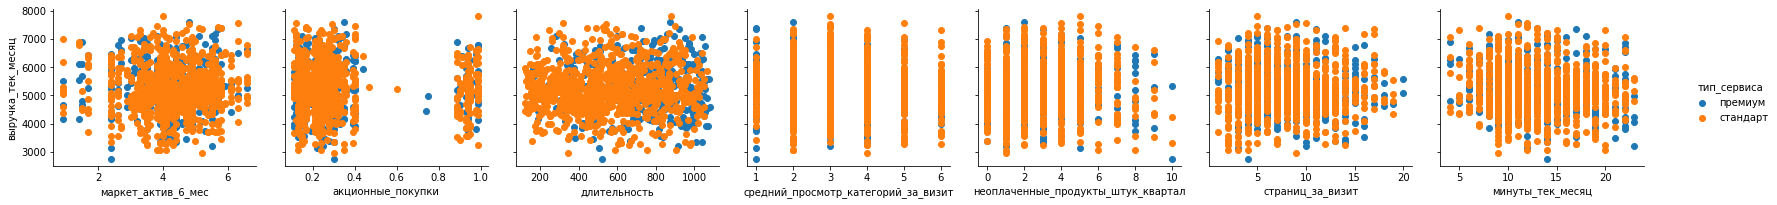

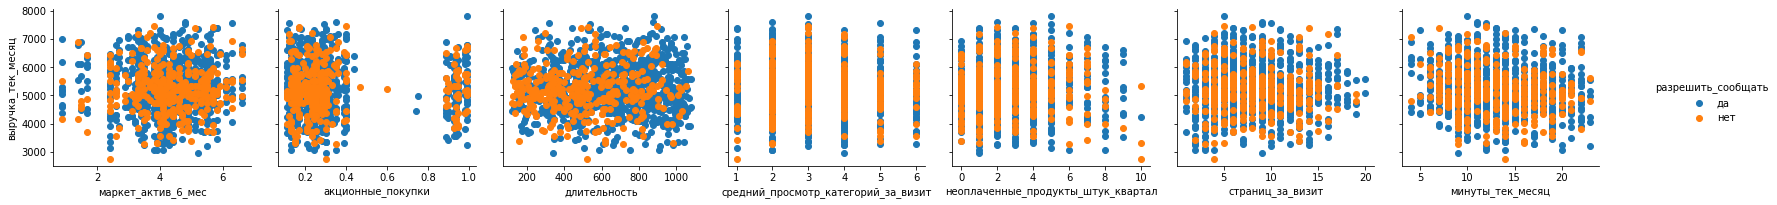

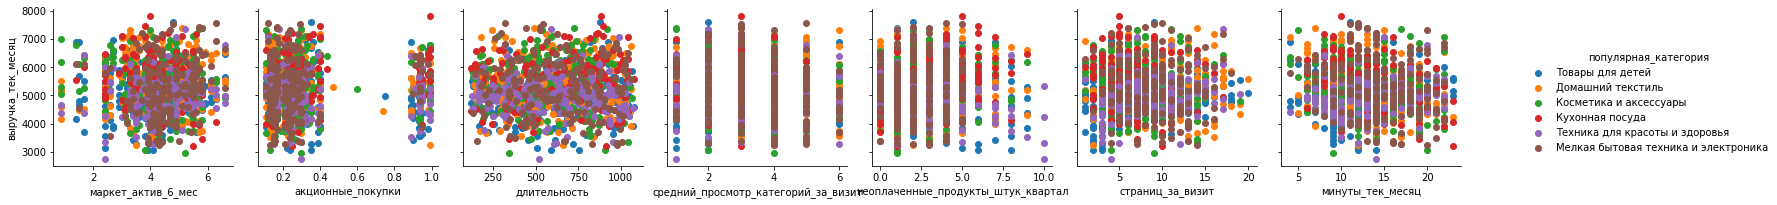

In [91]:
pair_grid(market,
          ['тип_сервиса','разрешить_сообщать','популярная_категория'],
          [ 'маркет_актив_6_мес','акционные_покупки','длительность',
           'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал',
           'страниц_за_визит', 'минуты_тек_месяц'],
          'выручка_тек_месяц')

**Вывод:**

На графике рассеяния выручки за текущий месяц от акционных покупок видна четкая граница - 0.45. По этой границе в дальнейшем преобразуем признак акционные покупки в бинарный.

interval columns not set, guessing: ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_пред_месяц', 'выручка_препред_месяц', 'выручка_тек_месяц', 'минуты_пред_месяц', 'минуты_тек_месяц']


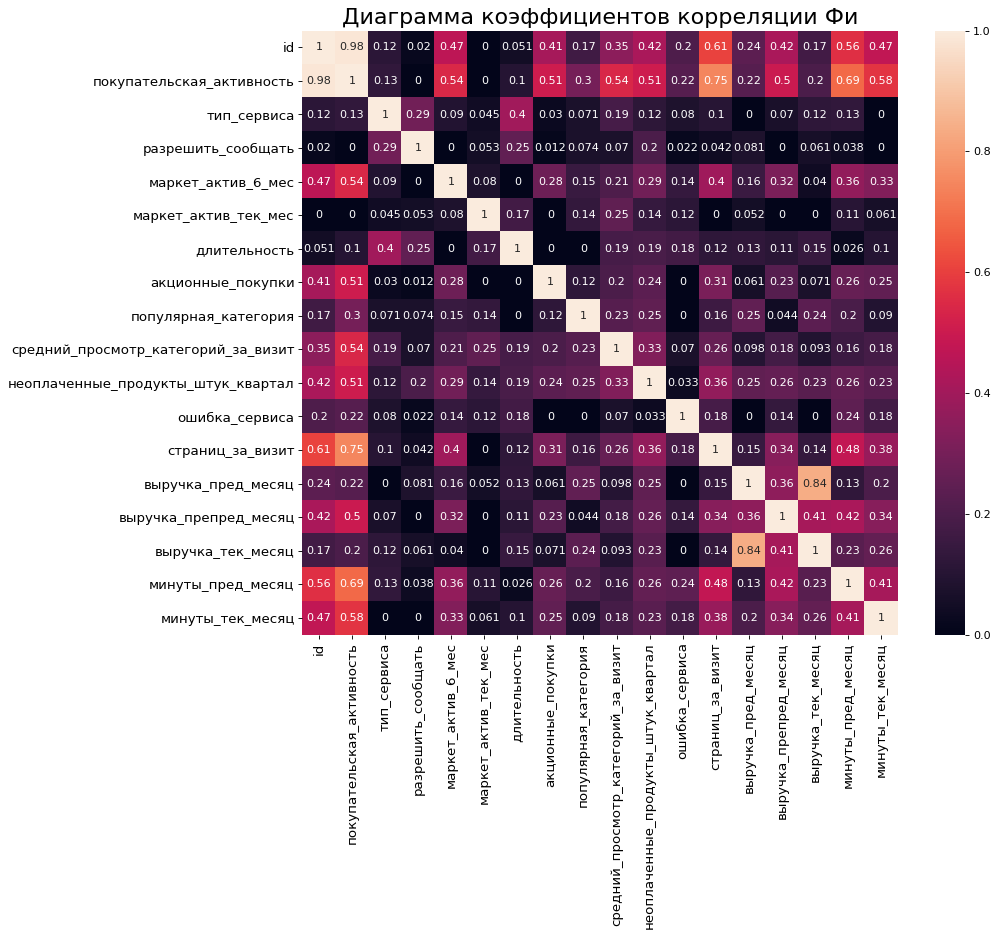

In [92]:
phik = market.phik_matrix()
plt.figure(figsize=(12,10), dpi=80)
sns.heatmap(phik, 
            annot=True)
plt.title('Диаграмма коэффициентов корреляции Фи', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

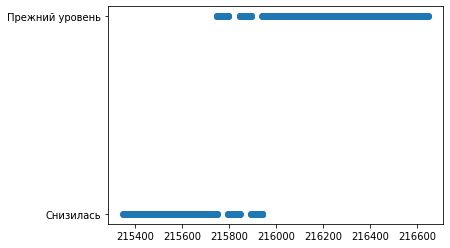

In [93]:
plt.scatter(market['id'], market['покупательская_активность'])
plt.show()

Можно сделать вывод, что сначала вносились id по типу активности "Снизилась", а затем начали вносить тип активности "Прежний уровень". 

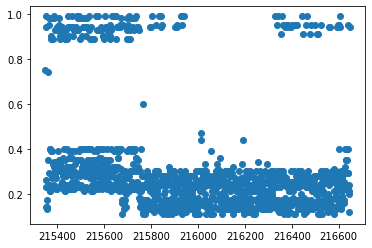

In [94]:
plt.scatter(market['id'], market['акционные_покупки'])
plt.show()

Так как большинство точек расположены внизу графика (значиния от 0 до 0.4), это указывает на то, что покупатели почти не совершают акционные покупки и эти акционные покупки не особо популярны среди покупателей.

Была обнаружена высокая корреляция между id и целевым признаком (покупательская_активность). id следует удалить, так как высокая корреляция может быть следствием утечки данных.

In [95]:
market = market.drop('id', axis=1)

Был преобразован признак 'акционные_покупки' в бинарный.

In [96]:
market['акционные_покупки'] = market['акционные_покупки'].apply( lambda x: 1 if x> 0.45 else 0)

In [97]:
interval_cols = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_пред_месяц', 'выручка_препред_месяц',
       'выручка_тек_месяц', 'минуты_пред_месяц', 'минуты_тек_месяц']

In [98]:
warnings.filterwarnings("ignore", message="Not enough unique value for variable покупательская_активность for analysis")

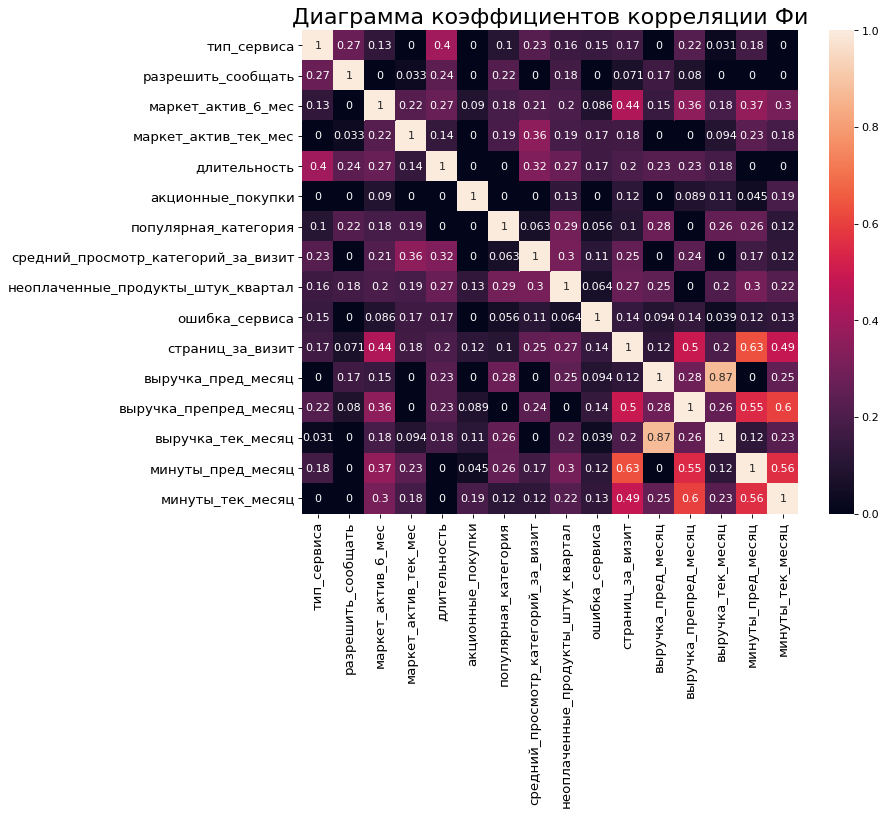

In [99]:
phik_matrix = (market[market['покупательская_активность'] == 'Снизилась']).phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(10,8), dpi=80)
sns.heatmap(phik_matrix, annot=True)
plt.title('Диаграмма коэффициентов корреляции Фи', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

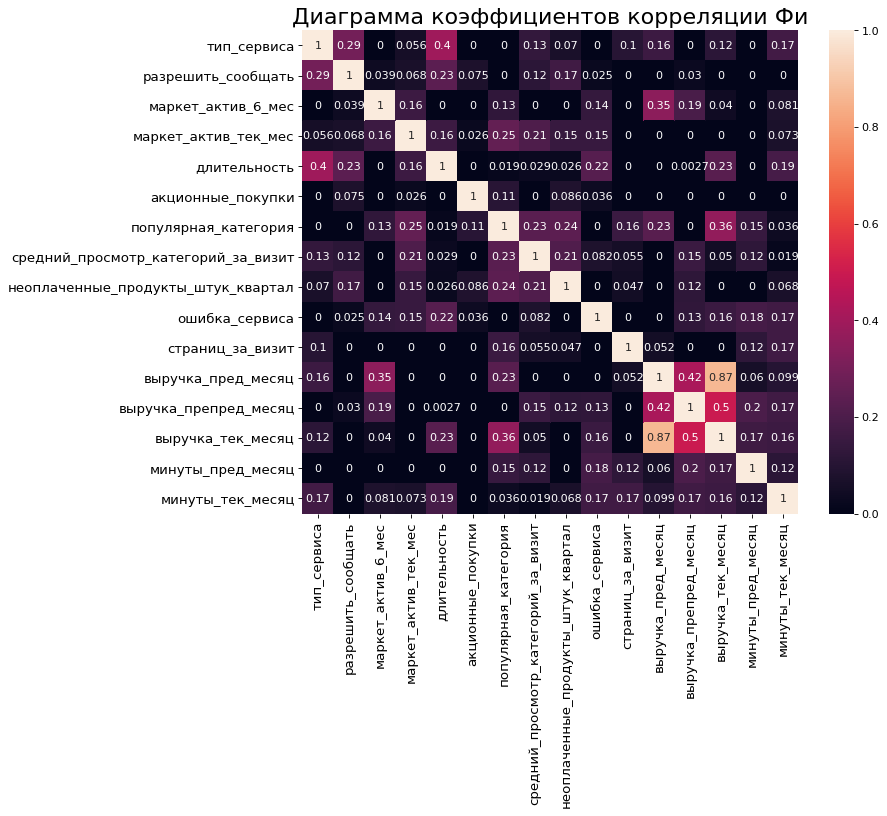

In [100]:
phik_matrix = (market[market['покупательская_активность'] == 'Прежний уровень']).phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(10,8), dpi=80)
sns.heatmap(phik_matrix, annot=True)
plt.title('Диаграмма коэффициентов корреляции Фи', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

1) У покупателей со снизившимся уровнем активности есть высокая корреляция между признаками выручка за текщий месяц и выручка за предыдущий месяц, также как и у покупателей с прежним уровнем активности.

2) У покупателей со снизившимся уровнем активности есть высокая корреляция между признаками страницы за визит и минуты за предыдущий месяц, а у покупателей с прежним уровнем активности такой корреляции нет.

3) У покупателей со снизившимся уровнем активности есть высокая корреляция между признаками выручка_препред_месяц и минут за текущий месяц, а у покупателей с прежним уровнем активности такой корреляции нет.

**Вывод:**

Целевой признак коррелирует с такими прзнаками, как:

1)страниц_за_визит

2)минут_пред_месяца

3)минут_тек_месяца

4)средний_просмотр_категорий_за_визит

5)маркет_актив 6 мес

6)акционные_покупки

7)неоплаченные_продукты_штук_квартал

8)выручка_препред_месяц

Также была обнаружена высокая корреляция между признаками выручка_тек_месяц и выручка_пред_месяц.

- У покупателей со снизившимся уровнем активности есть высокая корреляция между признаками выручка за текщий месяц и выручка за предыдущий месяц, также как и у покупателей с прежним уровнем активности.

- У покупателей со снизившимся уровнем активности есть высокая корреляция между признаками страницы за визит и минуты за предыдущий месяц, а у покупателей с прежним уровнем активности такой корреляции нет.

- У покупателей со снизившимся уровнем активности есть высокая корреляция между признаками выручка_препред_месяц и минут за текущий месяц, а у покупателей с прежним уровнем активности такой корреляции нет.

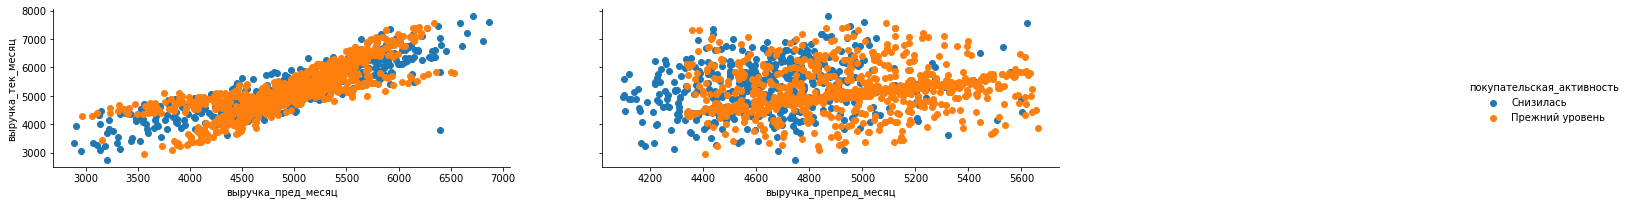

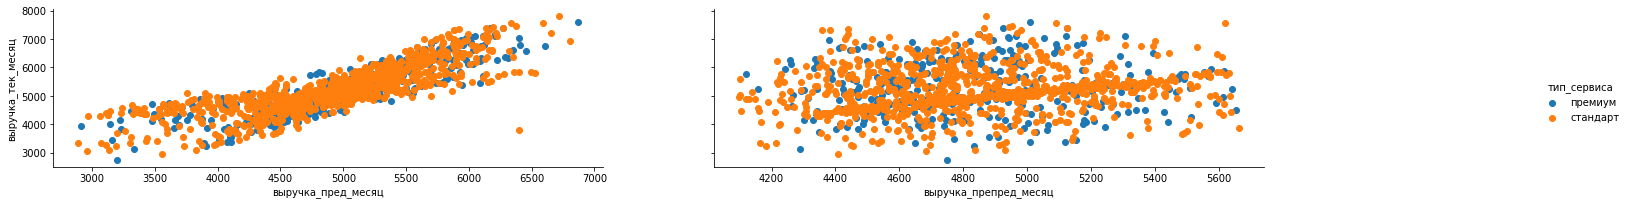

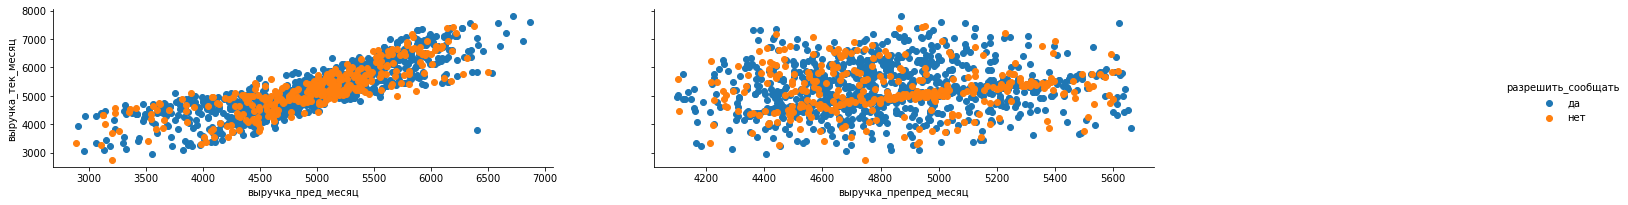

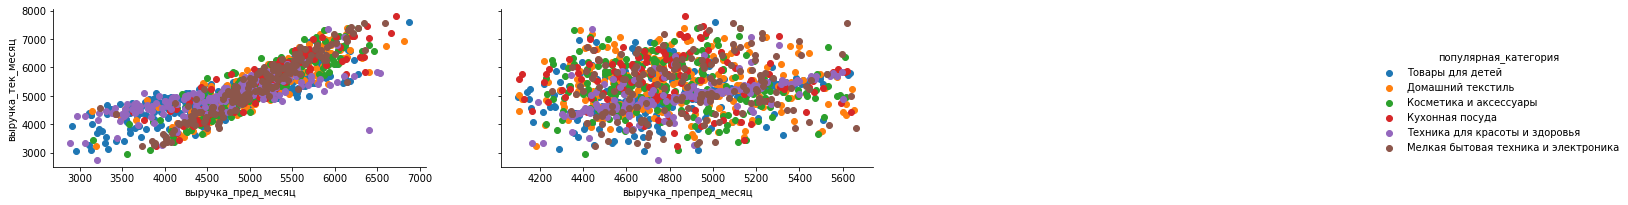

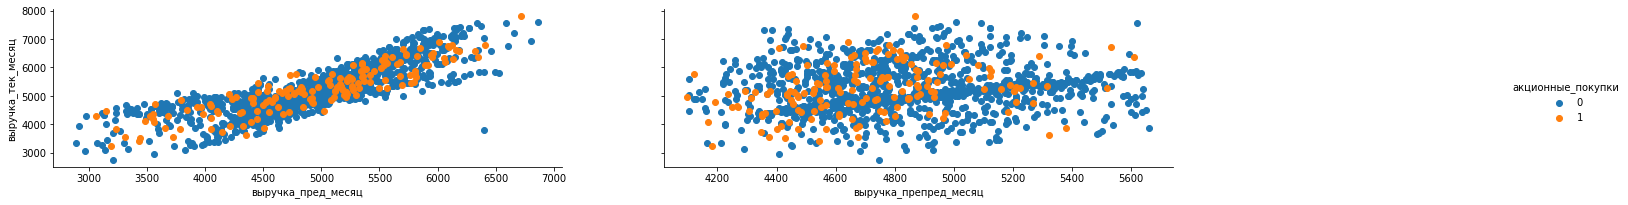

In [101]:
pair_grid(market,
          ['покупательская_активность','тип_сервиса','разрешить_сообщать','популярная_категория', 'акционные_покупки'],
          ['выручка_пред_месяц', 'выручка_препред_месяц'],
          'выручка_тек_месяц')

Видна прямая зависимость от покупательской активности на графике рассеяния выручки в текущем месяце от выручки в предыдущем месяце.

In [102]:
y = market['покупательская_активность']
X = market.select_dtypes(include='number')

X = sm.add_constant(X)

vif = pd.DataFrame()
vif['variables'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif

variables         VIF
0                                 const  342.826059
1                    маркет_актив_6_мес    1.213970
2                  маркет_актив_тек_мес    1.045435
3                          длительность    1.099848
4                     акционные_покупки    1.099727
5   средний_просмотр_категорий_за_визит    1.177267
6    неоплаченные_продукты_штук_квартал    1.195797
7                        ошибка_сервиса    1.079387
8                      страниц_за_визит    1.404890
9                    выручка_пред_месяц    4.262604
10                выручка_препред_месяц    1.610286
11                    выручка_тек_месяц    3.895783
12                    минуты_пред_месяц    1.520063
13                     минуты_тек_месяц    1.318023

**Вывод:**

Значение VIF у всех признаков менее 5, что говорит об отсутствии мультиколлинеарности.

**Вывод по разделу:**

1) Была обнаружена высокая корреляция между id и целевым признаком (покупательская_активность). id был удален.

2) Целевой признак коррелирует с такими признаками, как:

- страниц_за_визит

- минут_пред_месяца

- минут_тек_месяца

- средний_просмотр_категорий_за_визит

- маркет_актив 6 мес

- акционные_покупки

- неоплаченные_продукты_штук_квартал

- выручка_препред_месяц

Также была обнаружена высокая корреляция между признаками выручка_тек_месяц и выручка_пред_месяц.

- У покупателей со снизившимся уровнем активности есть высокая корреляция между признаками выручка за текщий месяц и выручка за предыдущий месяц, также как и у покупателей с прежним уровнем активности.

- У покупателей со снизившимся уровнем активности есть высокая корреляция между признаками страницы за визит и минуты за предыдущий месяц, а у покупателей с прежним уровнем активности такой корреляции нет.

- У покупателей со снизившимся уровнем активности есть высокая корреляция между признаками выручка_препред_месяц и минут за текущий месяц, а у покупателей с прежним уровнем активности такой корреляции нет.

3) На графике рассеяния выручки за текущий месяц от акционных покупок видна четкая граница - 0.45. По этой границе преобразовали признак акционные покупки в бинарный.

4) Значение VIF у всех признаков менее 5, что говорит об отсутствии мультиколлинеарности.

## Использование пайплайнов

In [103]:
market['покупательская_активность'].value_counts(normalize=True)

Прежний уровень    0.618827
Снизилась          0.381173
Name: покупательская_активность, dtype: float64

In [104]:
X = market.drop('покупательская_активность',axis=1)
y = market['покупательская_активность']


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE,
                                                    test_size=TEST_SIZE, stratify=y)


ohe_columns = ['популярная_категория', 'разрешить_сообщать','акционные_покупки']
ord_columns = ['тип_сервиса']
num_columns = ['маркет_актив_6_мес','маркет_актив_тек_мес','длительность','средний_просмотр_категорий_за_визит',
              'неоплаченные_продукты_штук_квартал','ошибка_сервиса','страниц_за_визит','выручка_пред_месяц',
               'выручка_препред_месяц','выручка_тек_месяц','минуты_пред_месяц','минуты_тек_месяц']

In [105]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [106]:
if label_encoder.classes_[1] != 'Снизилась':
    raise ValueError('Класс Снизилась не закодирован как 1.')

(f'Классы после кодировки: {label_encoder.classes_}')

"Классы после кодировки: ['Прежний уровень' 'Снизилась']"

In [107]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ]
)

In [108]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [109]:
data_preprocessor = ColumnTransformer([('ohe', ohe_pipe, ohe_columns),
                                       ('ord', ord_pipe, ord_columns),
                                       ('num', MinMaxScaler(), num_columns)],
                                      remainder='passthrough')

In [110]:
start = time.time()

In [111]:
pipe_lr = Pipeline([('preprocessor', data_preprocessor),
                    ('model', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear',penalty='l1', 
                                                 class_weight='balanced'))
                   ])

In [112]:
param_distributions_lr = {
    'preprocessor__num': CategoricalDistribution(['passthrough', StandardScaler(), MinMaxScaler(), RobustScaler()]),
    'model__C': distributions.IntDistribution(1,5)
}

In [113]:
pipe_tree = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [114]:
param_distributions_tree = {
    'preprocessor__num': CategoricalDistribution(['passthrough', StandardScaler(), MinMaxScaler(), RobustScaler()]),
    'model__max_depth': IntDistribution(2, 5),
    'model__max_features': IntDistribution(2, 5)
}

In [115]:
pipe_neighbors = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', KNeighborsClassifier())
])

In [116]:
param_distributions_neighbors = {
    'preprocessor__num': CategoricalDistribution(['passthrough', StandardScaler(), MinMaxScaler(), RobustScaler()]),
    'model__n_neighbors': IntDistribution(2,5)
}

In [117]:
pipe_svc = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', SVC(random_state=RANDOM_STATE,class_weight='balanced', probability=True))
])

In [118]:
param_distributions_svc = {
    'preprocessor__num': CategoricalDistribution(['passthrough', StandardScaler(), MinMaxScaler(), RobustScaler()]),
    'model__degree': IntDistribution(1,6)
}

In [119]:
f1_macro_scorer = make_scorer(f1_score, average='micro')

In [120]:
oscv_search_lr = OptunaSearchCV(
    estimator=pipe_lr,
    param_distributions=param_distributions_lr,
    n_trials=10,
    cv=5,
    random_state=RANDOM_STATE,
    scoring=f1_macro_scorer
)

In [121]:
oscv_search_tree = OptunaSearchCV(
    estimator=pipe_tree,
    param_distributions=param_distributions_tree,
    n_trials=10,
    cv=5,
    random_state=RANDOM_STATE,
    scoring=f1_macro_scorer
)

In [122]:
oscv_search_neighbors = OptunaSearchCV(
    estimator=pipe_neighbors,
    param_distributions=param_distributions_neighbors,
    n_trials=10,
    cv=5,
    random_state=RANDOM_STATE,
    scoring=f1_macro_scorer
)

In [123]:
oscv_search_svc = OptunaSearchCV(
    estimator=pipe_svc,
    param_distributions=param_distributions_svc,
    n_trials=10,
    cv=5,
    random_state=RANDOM_STATE,
    scoring=f1_macro_scorer
)

In [124]:
y_lr = oscv_search_lr.fit(X_train, y_train)

[I 2025-05-27 05:18:47,388] A new study created in memory with name: no-name-c92cfce4-e34a-4f76-86de-273153cfc821
[I 2025-05-27 05:18:47,590] Trial 0 finished with value: 0.8374464710547185 and parameters: {'preprocessor__num': StandardScaler(), 'model__C': 3}. Best is trial 0 with value: 0.8374464710547185.
[I 2025-05-27 05:18:48,400] Trial 1 finished with value: 0.8415543219666931 and parameters: {'preprocessor__num': 'passthrough', 'model__C': 2}. Best is trial 1 with value: 0.8415543219666931.
[I 2025-05-27 05:18:48,580] Trial 2 finished with value: 0.8374464710547185 and parameters: {'preprocessor__num': StandardScaler(), 'model__C': 2}. Best is trial 1 with value: 0.8415543219666931.
[I 2025-05-27 05:18:48,821] Trial 3 finished with value: 0.8415543219666931 and parameters: {'preprocessor__num': MinMaxScaler(), 'model__C': 5}. Best is trial 1 with value: 0.8415543219666931.
[I 2025-05-27 05:18:48,997] Trial 4 finished with value: 0.8374464710547185 and parameters: {'preprocessor_

In [125]:
y_tree = oscv_search_tree.fit(X_train, y_train)

[I 2025-05-27 05:18:50,163] A new study created in memory with name: no-name-101ac564-2a71-472b-b77f-a387f26ade50
[I 2025-05-27 05:18:50,337] Trial 0 finished with value: 0.7746920433518372 and parameters: {'preprocessor__num': StandardScaler(), 'model__max_depth': 3, 'model__max_features': 3}. Best is trial 0 with value: 0.7746920433518372.
[I 2025-05-27 05:18:50,512] Trial 1 finished with value: 0.8024425059476605 and parameters: {'preprocessor__num': RobustScaler(), 'model__max_depth': 3, 'model__max_features': 5}. Best is trial 1 with value: 0.8024425059476605.
[I 2025-05-27 05:18:50,659] Trial 2 finished with value: 0.8271636267512557 and parameters: {'preprocessor__num': 'passthrough', 'model__max_depth': 5, 'model__max_features': 5}. Best is trial 2 with value: 0.8271636267512557.
[I 2025-05-27 05:18:50,825] Trial 3 finished with value: 0.7725931800158603 and parameters: {'preprocessor__num': StandardScaler(), 'model__max_depth': 5, 'model__max_features': 2}. Best is trial 2 wit

In [126]:
y_neighbors = oscv_search_neighbors.fit(X_train, y_train)

[I 2025-05-27 05:18:51,987] A new study created in memory with name: no-name-52cfc591-2aec-4577-83f0-f978ee9259c4
[I 2025-05-27 05:18:52,395] Trial 0 finished with value: 0.852862807295797 and parameters: {'preprocessor__num': StandardScaler(), 'model__n_neighbors': 3}. Best is trial 0 with value: 0.852862807295797.
[I 2025-05-27 05:18:52,548] Trial 1 finished with value: 0.7397092254824214 and parameters: {'preprocessor__num': 'passthrough', 'model__n_neighbors': 3}. Best is trial 0 with value: 0.852862807295797.
[I 2025-05-27 05:18:52,719] Trial 2 finished with value: 0.852862807295797 and parameters: {'preprocessor__num': StandardScaler(), 'model__n_neighbors': 3}. Best is trial 0 with value: 0.852862807295797.
[I 2025-05-27 05:18:52,889] Trial 3 finished with value: 0.8198942638117895 and parameters: {'preprocessor__num': MinMaxScaler(), 'model__n_neighbors': 5}. Best is trial 0 with value: 0.852862807295797.
[I 2025-05-27 05:18:53,061] Trial 4 finished with value: 0.85286280729579

In [127]:
y_svc = oscv_search_svc.fit(X_train, y_train)

[I 2025-05-27 05:18:53,987] A new study created in memory with name: no-name-bc5b4196-a8b8-477a-80d5-af84bb8f63f1
[I 2025-05-27 05:18:54,590] Trial 0 finished with value: 0.8754850647634154 and parameters: {'preprocessor__num': StandardScaler(), 'model__degree': 3}. Best is trial 0 with value: 0.8754850647634154.
[I 2025-05-27 05:18:55,441] Trial 1 finished with value: 0.6584456780333069 and parameters: {'preprocessor__num': 'passthrough', 'model__degree': 2}. Best is trial 0 with value: 0.8754850647634154.
[I 2025-05-27 05:18:56,029] Trial 2 finished with value: 0.8754850647634154 and parameters: {'preprocessor__num': StandardScaler(), 'model__degree': 3}. Best is trial 0 with value: 0.8754850647634154.
[I 2025-05-27 05:18:56,626] Trial 3 finished with value: 0.856965371398361 and parameters: {'preprocessor__num': MinMaxScaler(), 'model__degree': 6}. Best is trial 0 with value: 0.8754850647634154.
[I 2025-05-27 05:18:57,212] Trial 4 finished with value: 0.8754850647634154 and paramete

In [128]:
oscv_search_time = time.time() - start
(f'Search time:{oscv_search_time}')

'Search time:13.660706520080566'

In [129]:
y_lr.best_params_

{'preprocessor__num': 'passthrough', 'model__C': 2}

In [130]:
y_tree.best_params_

{'preprocessor__num': 'passthrough',
 'model__max_depth': 5,
 'model__max_features': 5}

In [131]:
y_neighbors.best_params_

{'preprocessor__num': StandardScaler(), 'model__n_neighbors': 4}

In [132]:
y_svc.best_params_

{'preprocessor__num': StandardScaler(), 'model__degree': 3}

In [133]:
y_lr.best_score_

0.8415543219666931

In [134]:
y_tree.best_score_

0.8271636267512557

In [135]:
y_neighbors.best_score_

0.8672640761300556

In [136]:
y_svc.best_score_

0.8754850647634154

In [137]:
y_test_pred = oscv_search_svc.predict(X_test)

In [138]:
f'Метрика f1-score на тестовой выборке: {f1_score(y_test, y_test_pred, average="micro")}'

'Метрика f1-score на тестовой выборке: 0.904320987654321'

**Вывод по разделу:**

1) Были добавлены новые признаки:

- акционные покупки (бинарный)

2) Были обучены 4 модели - модель логистической регрессии, модель дерева решений, модель ближайших соседей и модель метода опорных векторов - среди которых была выбрана лучшая. Использовав метрику f1, так как есть дисбаланс классов, была выбрана лучшая модель - SVC{'preprocessor__num': StandardScaler(), 'model__degree': 3}. 

Метрика f1 на тренировочной выборке - 0,88.

Метрика f1 на тестовой выборке - 0,90.

## Анализ важности признаков

In [139]:
oscv_search_svc.best_estimator_.named_steps

{'preprocessor': ColumnTransformer(remainder='passthrough',
                   transformers=[('ohe',
                                  Pipeline(steps=[('simpleImputer_ohe',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('ohe',
                                                   OneHotEncoder(drop='first',
                                                                 sparse_output=False))]),
                                  ['популярная_категория', 'разрешить_сообщать',
                                   'акционные_покупки']),
                                 ('ord',
                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                   SimpleImputer(strategy='most_freq...
                                                   SimpleImputer(strategy='most_frequent'))]),
                                  ['тип_сервиса']),
             

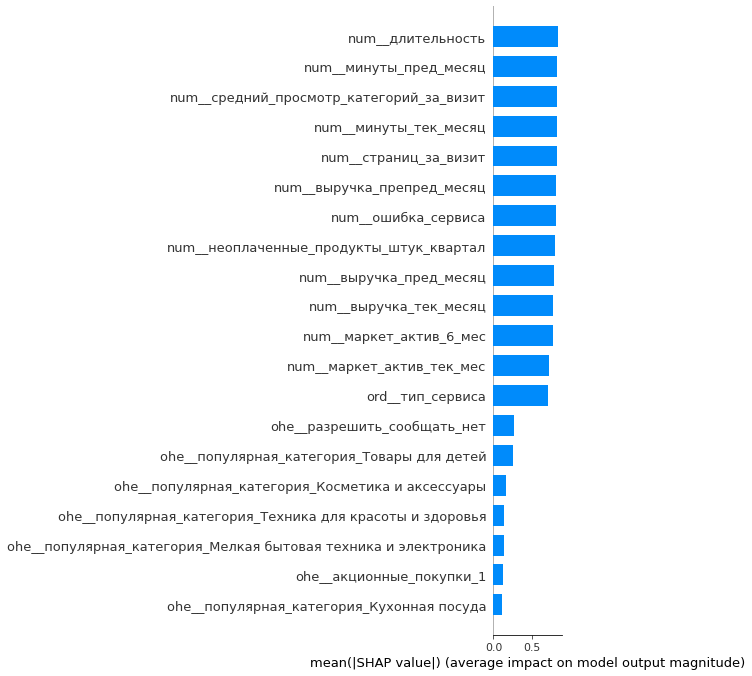

In [140]:
X_train_1 = oscv_search_svc.best_estimator_['preprocessor'].fit_transform(X_train)

best_model = oscv_search_svc.best_estimator_['model'].fit(X_train_1, y_train)
explainer = shap.PermutationExplainer(best_model, X_train_1)

labels = oscv_search_svc.best_estimator_[:-1].get_feature_names_out()

shap.summary_plot(X_train_1, plot_type='bar', feature_names=labels) 

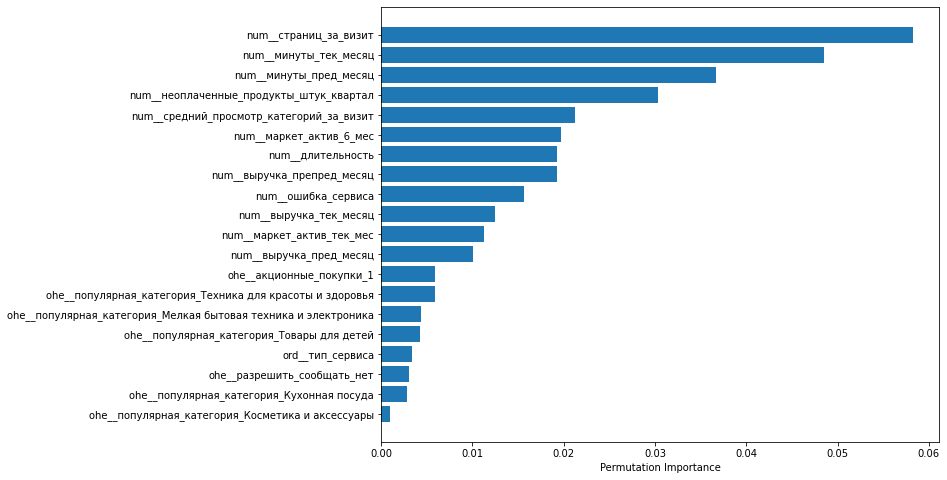

In [141]:
result = permutation_importance(best_model, X_train_1, y_train, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10,8))
plt.barh(labels[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel('Permutation Importance')
plt.show()

**Вывод:**
1) Как показывает метод Shap, сильнее всего на прогноз модели влияют признаки - длительность и минуты за предыдущий месяц. Метод Permutation Importance показывает, что сильнее всего на прогноз модели влияют признаки - страниц за визит и минуты за текущий месяц. Но результаты этих методов могут различаться из-за различий в подходах и интерпретации важности признаков.

2) Признак популярная категория мало влияет на прогноз модели.

3) Можно сделать вывод, что чем больше покупатель проводит времени на сайте, тем больше вероятность того, что он купит какой-либо товар. И уже почти не важно в какой категории он будет смотреть товары.

## Сегментация покупателей

**8.1 Сегментация покупателей.**

In [142]:
y_test_proba = oscv_search_svc.predict_proba(X_test)

In [143]:
y_test_proba.shape

(324, 2)

In [144]:
oscv_search_svc.classes_

array([0, 1])

In [145]:
X_test['вероятность_снижения_акт'] = y_test_proba[:,1]
(X_test.sort_values(by='вероятность_снижения_акт', ascending=False)).head(5)

тип_сервиса разрешить_сообщать  маркет_актив_6_мес  маркет_актив_тек_мес  \
95      премиум                 да                 3.1                     4   
322    стандарт                 да                 4.1                     4   
112    стандарт                 да                 3.5                     3   
231    стандарт                нет                 3.6                     3   
277    стандарт                 да                 4.1                     4   

     длительность  акционные_покупки    популярная_категория  \
95            893                  0         Кухонная посуда   
322           490                  1         Кухонная посуда   
112           720                  0       Домашний текстиль   
231           710                  0        Товары для детей   
277           464                  1  Косметика и аксессуары   

     средний_просмотр_категорий_за_визит  неоплаченные_продукты_штук_квартал  \
95                                     2                                   4   
322                                    3                                   7   
112                                    2                                   6   
231                                    3                                   5   
277                                    2                                   5   

     ошибка_сервиса  страниц_за_визит  выручка_пред_месяц  \
95                3                 2              6291.5   
322               3                 2              5415.0   
112               4                 2              5864.5   
231               2                 1              5516.5   
277               1                 3              5348.5   

     выручка_препред_месяц  выручка_тек_месяц  минуты_пред_месяц  \
95                  4691.0             6378.6                  5   
322                 4563.0             5723.1                  9   
112                 4729.0             6063.4                 10   
231                 4393.0             6202.9                  6   
277                 4777.0             5674.8                 11   

     минуты_тек_месяц  вероятность_снижения_акт  
95                  8                  0.996331  
322                11                  0.994847  
112                11                  0.994309  
231                11                  0.992740  
277                 6                  0.992582

In [146]:
y_pred = np.argmax(y_test_proba, axis=1)
accuracy = np.mean(y_pred == y_test)
f'Accuracy: {accuracy}'

'Accuracy: 0.904320987654321'

In [147]:
def scatter_plot(column):
    sns.scatterplot(data=X_test, x='вероятность_снижения_акт', y=column)
    plt.show()

In [148]:
def x_group(column):
    return (X_test.groupby(column)['вероятность_снижения_акт'].median()).sort_values(ascending=False)

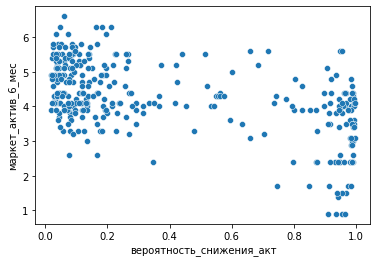

In [149]:
scatter_plot('маркет_актив_6_мес')

In [150]:
x_group('маркет_актив_6_мес')

маркет_актив_6_мес
3.0    0.987971
2.9    0.985097
3.1    0.982643
3.4    0.966460
1.5    0.953431
2.4    0.944356
0.9    0.943751
1.4    0.940527
3.5    0.912623
1.7    0.912565
5.6    0.715405
3.6    0.595039
2.6    0.556577
4.2    0.480702
4.0    0.451253
5.0    0.346870
3.2    0.271180
3.8    0.232129
4.6    0.230266
3.9    0.193143
3.3    0.175006
6.3    0.172387
4.4    0.167445
5.2    0.150134
3.7    0.139749
4.1    0.130966
5.5    0.122414
4.7    0.119729
4.8    0.116601
4.3    0.104077
5.1    0.083739
5.7    0.075050
5.3    0.073223
6.1    0.072366
5.4    0.070658
5.8    0.069327
6.6    0.059907
4.9    0.056355
Name: вероятность_снижения_акт, dtype: float64

Покупатели с выской вероятностью снижения активности имеют маркетинговую активность за 6 месяцув - 3,1 и менее.

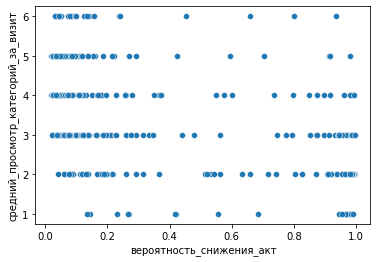

In [151]:
scatter_plot('средний_просмотр_категорий_за_визит')

In [152]:
x_group('средний_просмотр_категорий_за_визит')

средний_просмотр_категорий_за_визит
1    0.945956
2    0.543084
3    0.200848
4    0.109670
6    0.090771
5    0.082898
Name: вероятность_снижения_акт, dtype: float64

Покупатели с выской вероятностью снижения активности имеют число просмотров категорий за визит в течение последнего месяца - 2 и менее.

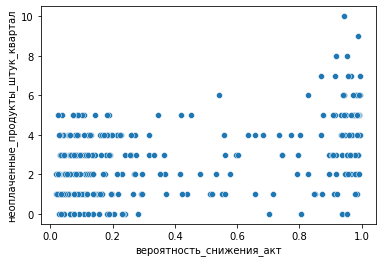

In [153]:
scatter_plot('неоплаченные_продукты_штук_квартал')

In [154]:
x_group('неоплаченные_продукты_штук_квартал')

неоплаченные_продукты_штук_квартал
9     0.987288
7     0.956523
10    0.944832
6     0.944356
8     0.935015
5     0.924310
4     0.213254
2     0.194463
0     0.136147
3     0.134974
1     0.100141
Name: вероятность_снижения_акт, dtype: float64

Покупатели с выской вероятностью снижения активности имеют число неоплаченных товаров в корзине за последние 3 месяца - 5 и более.

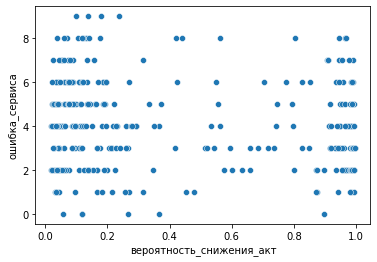

In [155]:
scatter_plot('ошибка_сервиса')

In [156]:
x_group('ошибка_сервиса')

ошибка_сервиса
3    0.520128
1    0.255979
2    0.225632
0    0.192740
4    0.189189
9    0.159417
8    0.158008
7    0.147126
5    0.135714
6    0.113046
Name: вероятность_снижения_акт, dtype: float64

Покупатели с выской вероятностью снижения активности в среднем имеют число ошибка_сервиса - 3.

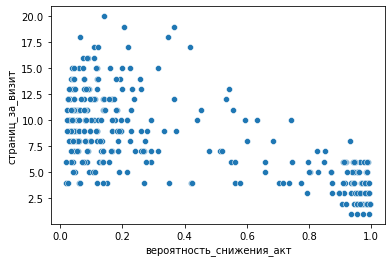

In [157]:
scatter_plot('страниц_за_визит')

In [158]:
x_group('страниц_за_визит')

страниц_за_визит
2     0.969412
3     0.964688
1     0.964609
4     0.907904
5     0.848685
6     0.657659
19    0.285905
18    0.204299
7     0.185823
17    0.168461
20    0.140700
15    0.117173
12    0.104391
10    0.104117
14    0.096481
9     0.096428
8     0.088194
16    0.086811
13    0.081688
11    0.069855
Name: вероятность_снижения_акт, dtype: float64

Покупатели с выской вероятностью снижения активности имеют среднее количество страниц за визит - 6 и менее.

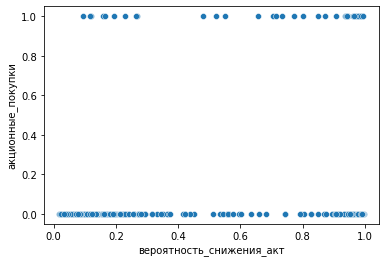

In [159]:
scatter_plot('акционные_покупки')

In [160]:
x_group('акционные_покупки')

акционные_покупки
1    0.938019
0    0.140700
Name: вероятность_снижения_акт, dtype: float64

Так как для обучения модели признак акционые покупки был преобразован, 1 означает долю акционных покупок 0,45 и выше.Покупатели с выской вероятностью снижения активности имеют среднемесячную долю покупок по акции от общего числа покупок за последние 6 месяцев - 0,45 и выше.

**8.2 Сравнение двух групп покупателей: покупатели с высокой вероятностью снижения активности и покупатели с маленькой вероятностью.**

In [161]:
decreased_act = X_test.query('вероятность_снижения_акт > 0.5')
decreased_act.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112 entries, 306 to 322
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   тип_сервиса                          112 non-null    object 
 1   разрешить_сообщать                   112 non-null    object 
 2   маркет_актив_6_мес                   112 non-null    float64
 3   маркет_актив_тек_мес                 112 non-null    int64  
 4   длительность                         112 non-null    int64  
 5   акционные_покупки                    112 non-null    int64  
 6   популярная_категория                 112 non-null    object 
 7   средний_просмотр_категорий_за_визит  112 non-null    int64  
 8   неоплаченные_продукты_штук_квартал   112 non-null    int64  
 9   ошибка_сервиса                       112 non-null    int64  
 10  страниц_за_визит                     112 non-null    int64  
 11  выручка_пред_месяц            

In [162]:
increased_act = X_test.query('вероятность_снижения_акт < 0.1')
increased_act.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 813 to 722
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   тип_сервиса                          109 non-null    object 
 1   разрешить_сообщать                   109 non-null    object 
 2   маркет_актив_6_мес                   109 non-null    float64
 3   маркет_актив_тек_мес                 109 non-null    int64  
 4   длительность                         109 non-null    int64  
 5   акционные_покупки                    109 non-null    int64  
 6   популярная_категория                 109 non-null    object 
 7   средний_просмотр_категорий_за_визит  109 non-null    int64  
 8   неоплаченные_продукты_штук_квартал   109 non-null    int64  
 9   ошибка_сервиса                       109 non-null    int64  
 10  страниц_за_визит                     109 non-null    int64  
 11  выручка_пред_месяц            

In [163]:
def pie_plot(column):
    data = decreased_act[column].value_counts()
    plt.figure(figsize=(10,6))
    plt.pie(data, labels=data.index, autopct='%1.2f%%')
    my_circle=plt.Circle((0,0), 0.7, color='white')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.title(f'Соотношение {column} у покупателей с высокой веротностью снижения активности')
    plt.show()

In [164]:
def in_pie_plot(column):
    data = increased_act[column].value_counts()
    plt.figure(figsize=(10,6))
    plt.pie(data, labels=data.index, autopct='%1.2f%%')
    my_circle=plt.Circle((0,0), 0.7, color='white')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.title(f'Соотношение {column} у покупателей с низкой веротностью снижения активности')
    plt.show()

**Коммуникация с клиентом**

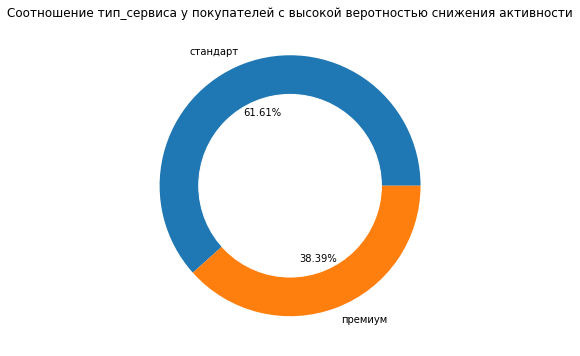

In [165]:
pie_plot('тип_сервиса')

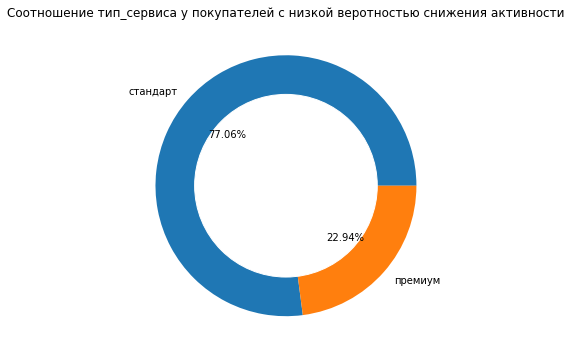

In [166]:
in_pie_plot('тип_сервиса')

После сравнения можно сделать вывод, что не все функции премиум сервиса удовлетворяют покупателей и стоит поработать над этим типом сервиса.

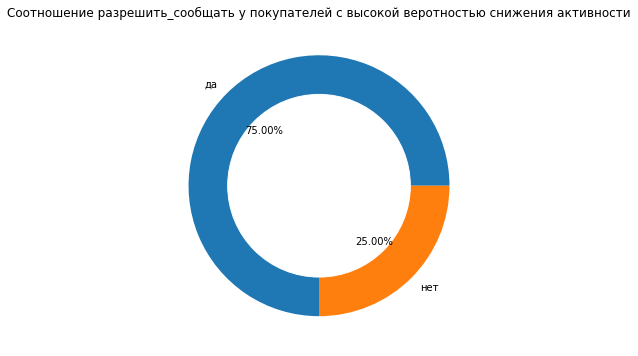

In [167]:
pie_plot('разрешить_сообщать')

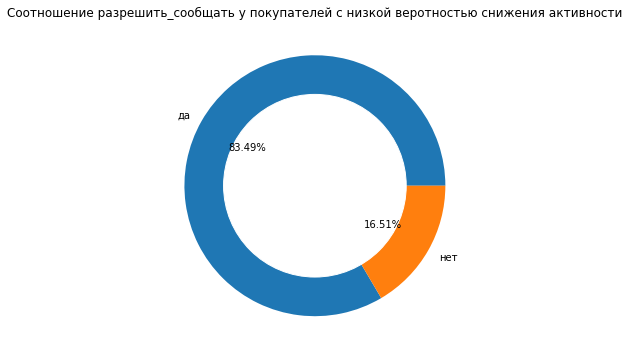

In [168]:
in_pie_plot('разрешить_сообщать')

После сравнения можно сделать вывод, что массовая рассылка дополнительной информации работает в 50% случаев.

In [169]:
def hist_compare(column):
    plt.figure(figsize=(5, 3))
    sns.boxplot(decreased_act[column]).set_title(f'Boxplot {column} - Высокая вероятность снижения активности')
    plt.xticks(rotation=90)
    plt.show()
    
    plt.figure(figsize=(5, 3))
    sns.boxplot(increased_act[column]).set_title(f'Boxplot {column} - Низкая вероятность снижения активности')
    plt.xticks(rotation=90)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.hist(decreased_act[column], bins=20, alpha=0.5, label='Высокая вероятность снижения активности')
    plt.hist(increased_act[column], bins=20, alpha=0.5, label='Низкая вероятность снижения активности')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.title(f'Гистограмма для {column}')
    plt.legend()
    plt.show()

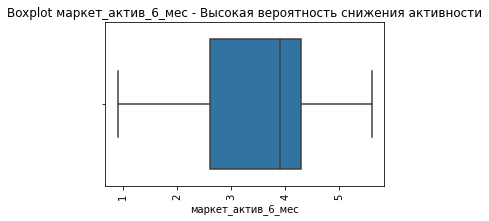

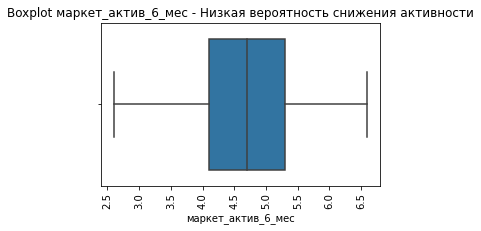

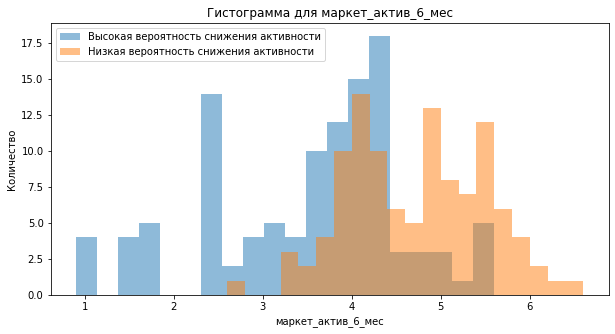

In [170]:
hist_compare('маркет_актив_6_мес')

У покупателей с высокой вероятностью снижения активности маркетинговая активность за 6 месяцев меньше, чем у покупателей с низкой вероятностью снижения активности. Это означает, что магазин вкладывал меньше денег и сил в таких клиентов.

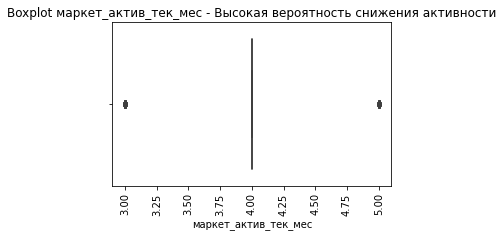

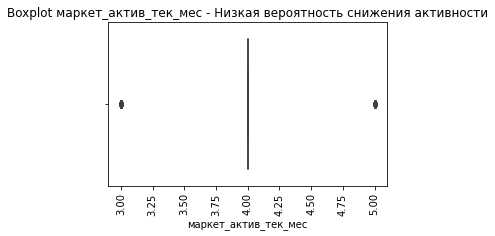

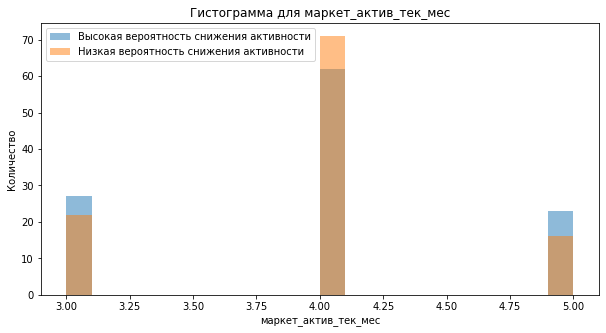

In [171]:
hist_compare('маркет_актив_тек_мес')

Маркетинговая активность за текущий месяц у покупателей с высокой вероятностью снижения активности даже больше, чем у покупателей с низкой вероятностью снижения активности. Значит в какой-то из 5 предыдущих месяцев была просадка по маркетинговой активности.

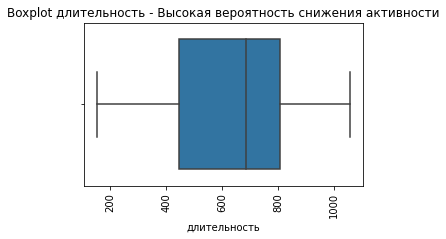

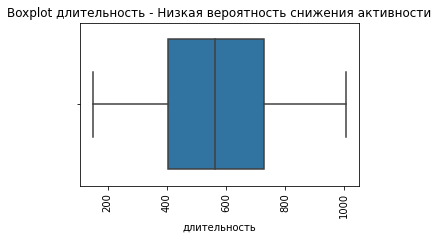

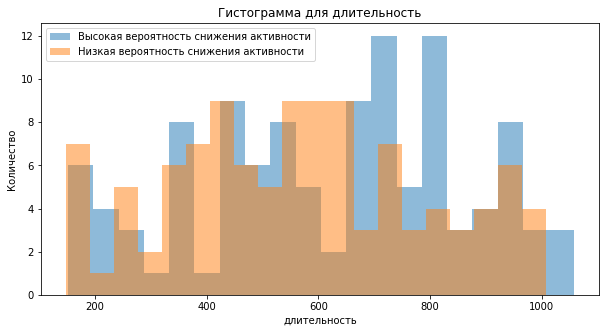

In [172]:
hist_compare('длительность')

У покупателей с высокой вероятностью снижения активности длительность (значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте) больше, чем у покупателей с низкой вероятностью снижения активности. Это говорит о том, что чем больше дней прошло с даты регистрации покупателя, тем больше вероятность, что покупатель снизит свою активность. Можно было бы предоставить акции или персонализированные предложения "старым" клиентам.

**Продуктовое поведение**

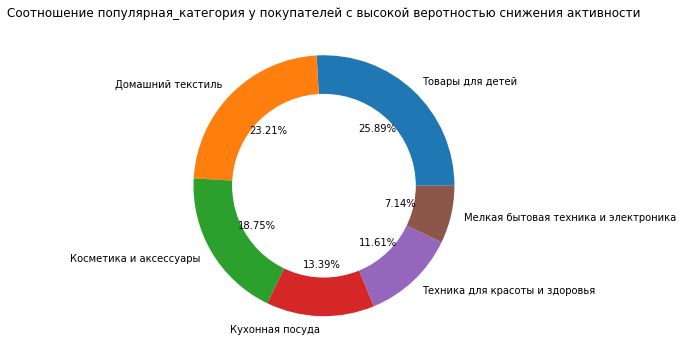

In [173]:
pie_plot('популярная_категория')

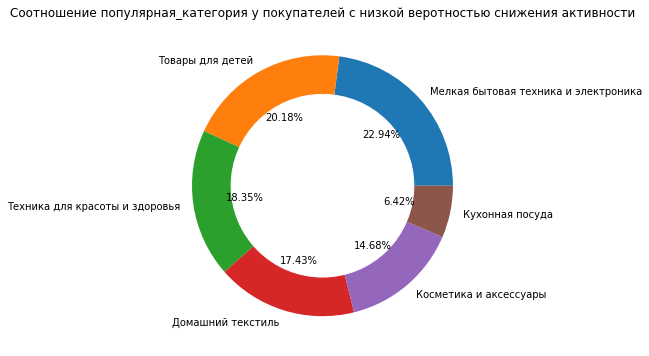

In [174]:
in_pie_plot('популярная_категория')

У покупателей с низкой вероятностью снижения активности видно более равномерное распределение популярности категорий, чем у покупателей с высокой вероятность, у которых в основном 2 популярные категории. 

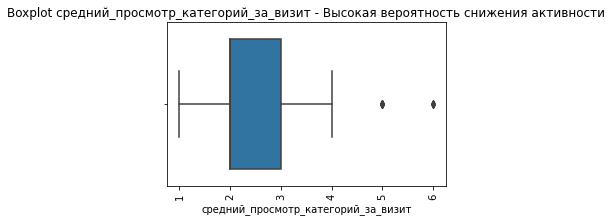

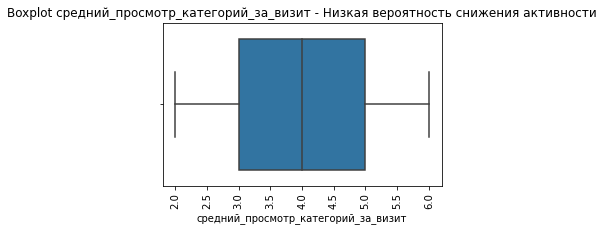

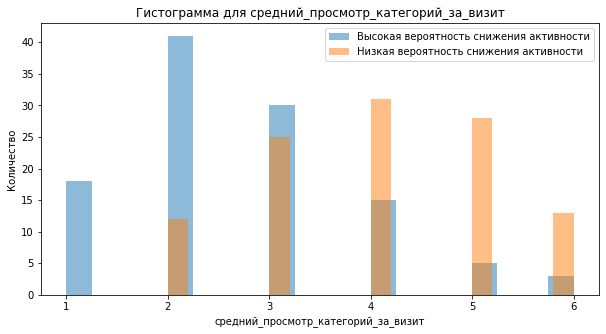

In [175]:
hist_compare('средний_просмотр_категорий_за_визит')

Покупатели с высокой вероятностью снижения активности просматривают меньше категорий, чем покупатели с низкой вероятностью снижения активности. Можно персонализировать рекомендации, то есть предлагать клиенту товары на основе его покупок и просмотров.

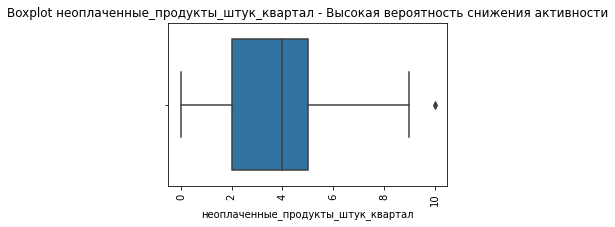

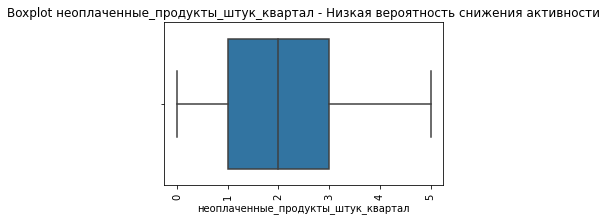

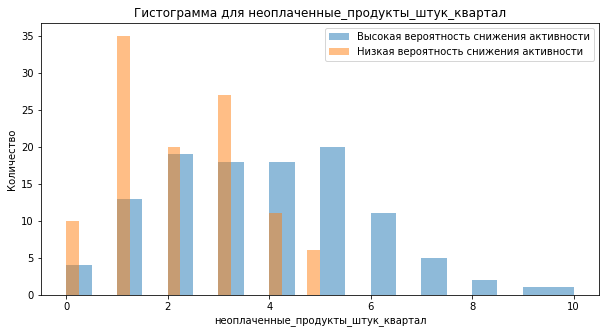

In [176]:
hist_compare('неоплаченные_продукты_штук_квартал')

Покупатели с высокой вероятностью снижения активности имеют неоплаченных продуктов в корзине больше, чем покупатели с низкой вероятностью снижения активности. Вполне вероятно, что покупатели могли добавить в корзину товары из одной категории и выбрать лучшую для себя, не купив при этом остальные. 

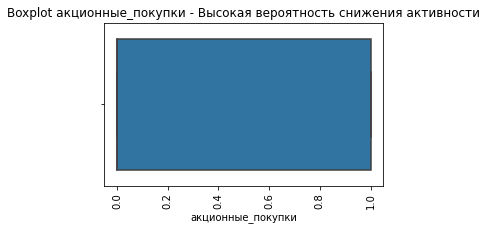

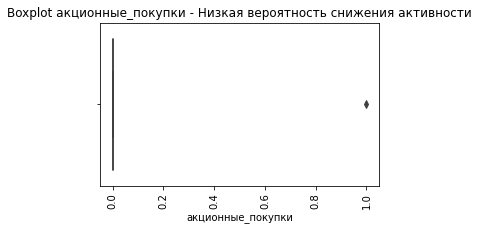

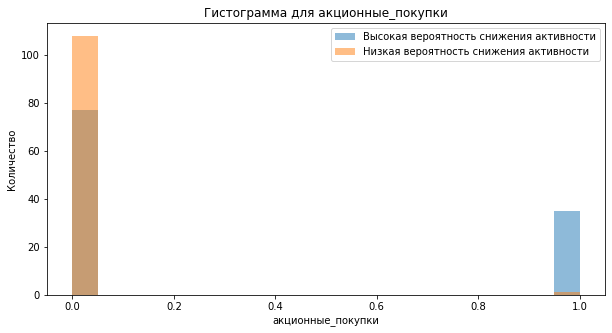

In [177]:
hist_compare('акционные_покупки')

У покупателей с высокой вероятностью снижения активности количество акционных покупок чуть больше, чем у покупателей с низкой вероятностью снижения активности. Когда акции заканчиваются у таких покупателей снижается активность.

**Поведение на сайте**

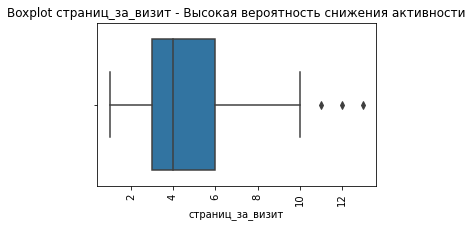

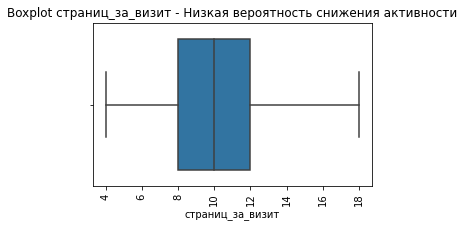

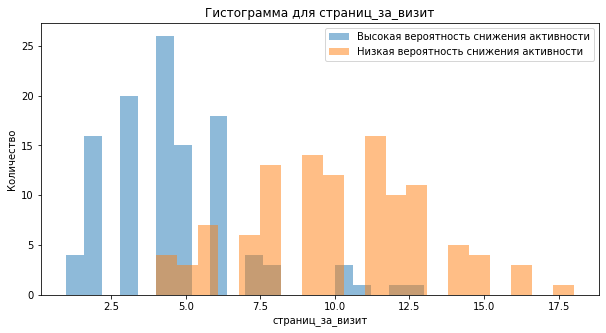

In [178]:
hist_compare('страниц_за_визит')

Покупатели с высокой вероятностью снижения активности имеют меньшее количество просмотренных страниц за один визит на сайт за последние 3 месяца, чем покупатели с низкой вероятностью снижения активности. Тут может быть несколько причин, например:

- неинтересные товары - ожидания покупателя могут не оправдаться и он быстро уходит;

- покупатель быстро переходит на нужную страницу и соответсвенно просматривает меньше страниц. Стоит добавить рекомендации персонализированных товаров по пути на нужную страницу.

**Финансовое поведение**

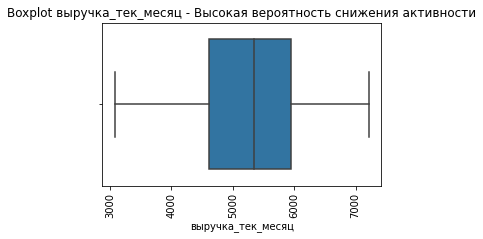

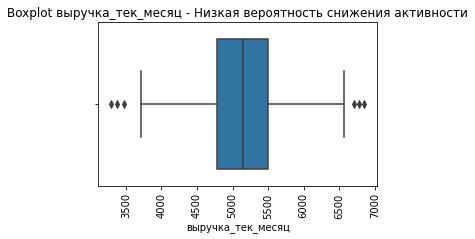

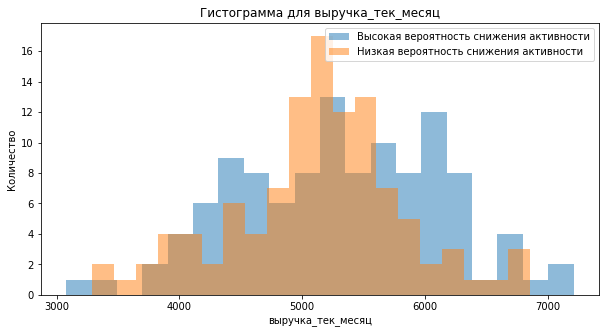

In [179]:
hist_compare('выручка_тек_месяц')

Покупатели с высокой вероятностью снижения активности имеют выручку в текущем месяце больше, а покупатели с низкой вероятностью снижения активности меньше.

**Динамика выручки по месяцам в зависимости от категории**

In [180]:
X_test_today = X_test.pivot_table(index='популярная_категория',
                                  values='выручка_тек_месяц', aggfunc='sum').sort_values(by='выручка_тек_месяц', ascending=False)
X_test_today

выручка_тек_месяц
популярная_категория                                   
Товары для детей                               394239.0
Домашний текстиль                              341050.5
Косметика и аксессуары                         307182.6
Мелкая бытовая техника и электроника           243394.3
Техника для красоты и здоровья                 237699.2
Кухонная посуда                                172365.0

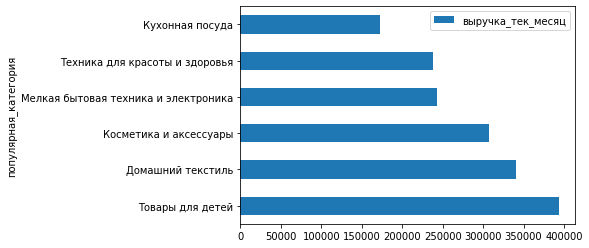

In [181]:
X_test_today.plot.barh()
plt.show()

В текущем месяце самый большой доход принесла категория - Товары для детей, а самый маленький - Кухонная посуда.

In [182]:
X_test_past = X_test.pivot_table(index='популярная_категория',
                                  values='выручка_пред_месяц', aggfunc='sum').sort_values(by='выручка_пред_месяц', ascending=False)
X_test_past

выручка_пред_месяц
популярная_категория                                    
Товары для детей                                369155.5
Домашний текстиль                               323884.0
Косметика и аксессуары                          292314.5
Мелкая бытовая техника и электроника            229418.0
Техника для красоты и здоровья                  219461.5
Кухонная посуда                                 161347.5

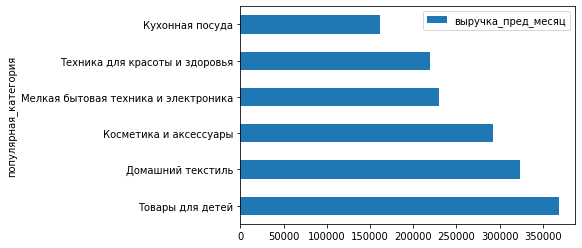

In [183]:
X_test_past.plot.barh()
plt.show()

В предыдущем месяце самый большой доход принесла категория - Товары для детей, а самый маленький - Кухонная посуда.

In [184]:
X_test_past_past = X_test.pivot_table(index='популярная_категория',
                                  values='выручка_препред_месяц', aggfunc='sum').sort_values(by='выручка_препред_месяц', ascending=False)
X_test_past_past

выручка_препред_месяц
популярная_категория                                       
Товары для детей                                   375696.0
Домашний текстиль                                  308409.0
Косметика и аксессуары                             281203.0
Техника для красоты и здоровья                     231772.0
Мелкая бытовая техника и электроника               218966.0
Кухонная посуда                                    147815.0

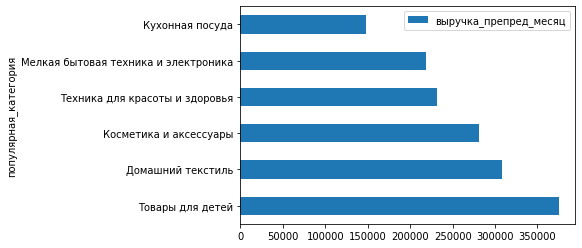

In [185]:
X_test_past_past.plot.barh()
plt.show()

В препредыдущем месяце самый большой доход принесла категория - Товары для детей, а самый маленький - Кухонная посуда.

**Вывод по разделу:**

1. *После сравнения двух групп покупателей были сделаны следующие выводы:*

*Коммуникация с клиентом*

1) Не все функции премиум сервиса удовлетворяют покупателей и стоит поработать над этим типом сервиса.

2) Массовая рассылка дополнительной информации работает в 50% случаев. Для покупателей с высокой вероятностью снижения активности массовая рассылка не подходит и не стоит тратить на это деньги.

3) У покупателей с высокой вероятностью снижения активности маркетинговая активность за 6 месяцев меньше, чем у покупателей с низкой вероятностью снижения активности. Это означает, что магазин вкладывал меньше денег и сил в таких клиентов.

4) Маркетинговая активность за текущий месяц у покупателей с высокой вероятностью снижения активности даже больше, чем у покупателей с низкой вероятностью снижения активности. Значит в какой-то из 5 предыдущих месяцев была просадка по маркетинговой активности. Стоит выяснить в чем причина просадки.

5) У покупателей с высокой вероятностью снижения активности длительность (значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте) больше, чем у покупателей с низкой вероятностью снижения активности. Это говорит о том, что чем больше дней прошло с даты регистрации покупателя, тем больше вероятность, что покупатель снизит свою активность. Можно было бы предоставить персонализированные предложения "старым" клиентам.

*Продуктовое поведение*

1) У покупателей с низкой вероятностью снижения активности видно более равномерное распределение популярности категорий, чем у покупателей с высокой вероятность, у которых в основном 2 популярные категории. Стоить добавить товары из разных категорий в рекомендации, но в соответствии с предпочтениями покупателя.

2) Покупатели с высокой вероятностью снижения активности просматривают меньше категорий, чем покупатели с низкой вероятностью снижения активности. Можно персонализировать рекомендации, то есть предлагать клиенту товары на основе его покупок и просмотров.

3) Покупатели с высокой вероятностью снижения активности имеют неоплаченных продуктов в корзине больше, чем покупатели с низкой вероятностью снижения активности. Вполне вероятно, что покупатели могли добавить в корзину товары из одной категории и выбрать лучшую для себя, не купив при этом остальные. 

4) У покупателей с высокой вероятностью снижения активности количество акционных покупок больше, чем у покупателей с низкой вероятностью снижения активности. Когда акции заканчиваются у таких покупателей снижается активность.

*Поведение на сайте*

1) Покупатели с высокой вероятностью снижения активности проводят меньше времени на сайте, чем с низкой вероятностью снижения активности.

2) Покупатели с высокой вероятностью снижения активности имеют меньшее количество просмотренных страниц за один визит на сайт за последние 3 месяца, чем покупатели с низкой вероятностью снижения активности. Тут может быть несколько причин, например:

- неинтересные товары - ожидания покупателя могут не оправдаться и он быстро уходит;

- покупатель быстро переходит на нужную страницу и соответственно просматривает меньше страниц. Стоит добавить рекомендации персонализированных товаров по пути на нужную страницу.

*Финансовое поведение*

Покупатели с высокой вероятностью снижения активности имеют выручку в текущем месяце больше, а покупатели с низкой вероятностью снижения активности меньше.

2. *Динамика выручки по месяцам в зависимости от категории:*

В течение всех трех месяцев самый большой доход приносила категория - Товары для детей, а самый маленький - Кухонная посуда. Для увеличения прибыли можно:

- предлагать скидки при покупке нескольких товаров из категории кухонной посуды

- рекомендовать кухонную посуду вместе с популярными товарами для детей

## Общий вывод

*1. Загрузка данных*
- В датафрейме market_file - 1300 строк, в market_money - 3900 строк, в market_time - 2600 строк, в data_money - 1300 строк.

- Типы данных соответствуют содержанию во всех датафреймах.

*2. Предобработка данных*

- Была исправлена стилистика в названиях столбцов. Названия были переведены в нижний регистр.

- В данных датафреймов был удален нижний пробел между словами.

- Пропущенных значений не было обнаружено.

- Явных дубликатов не было обнаружено.

- В датафреймах market_file и market_time были устранены неявные дубликаты.

*3. Исследовательский анализ*

*3.1 Исследовательский анализ датафрейма market_file*

 - у целевого признака присутствует дисбаланс данных в классах.

- тип сервиса "стандарт" преобладает над типом сервиса "премиум" и что покупатели с прежним уровнем активности предпочитают тип сервиса - стандарт.

- покупатели чаще разрешают присылать им информацию, чем не разрешают. Покупатели с прежним уровнем активности и покупатели со снизившимся уровнем активности разрешают присылать им информацию.

- средняя маркетинговая активность за 6 месяцев - 4,2. Минимальное значение - 0,9 не является выбросом. Высокая маркетинговая активность за 6 месяцев в основном у покупателей с прежним уровнем активности.

- средняя маркетинговая активность за текущий месяцев - 4,0. 

- в среднем проходит 600 дней с момента регистрации покупателя на сайте. Большая длительность у покупателей со снизившимся уровнем активности.

- в среднем покупатели не отслеживают акционные товары. При корреляционном анализе необходимо выявить границу между покупкой по акции и отсутствием покупки по акции.

- акционные товары приобретают покупатели со снизившимся уровнем активности.

- самой популярной категорией является - Товары для детей.

- в среднем просматривается 3 категории за визит. Покупатели с прежним уровнем активности просматривают 4 категории за визит, а покупатели со снизившейся активностью - 2-3 категории.

- в среднем общее число неоплаченных товаров в корзине за последние 3 месяца - 1 или 2 товара. Покупатели с прежним уровнем активности не оплачивают 2 товара в корзине, а покупатели со снизившейся активностью - 4 товара.

- в среднем происходит 4 сбоя во время посещения сайта. У покупателей с прежним уровнем активности в среднем 4 сбоя как и у покупателей со снизившейся активностью.

- среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца - 8 страниц. У покупателей с прежним уровнем активности 10 просмотренных страниц за визит, а у покупателей со снизившейся активностью - 5 страниц

*3.2 Исследовательский анализ датафрейма market_money.*

 - выручка зафиксирована у одинакового количества клиентов за разный период.
 
 - выручка у текущего периода больше, чем у предыдущего и препредыдущего периода.

*3.3 Исследовательский анализ датафрейма market_time.*

 - время зафиксированное в определённый период получено от одинакового количества пользователей.

 - клиенты проводили время на сайте одинаковое количество времени и в текущем месяце и в предыдущем месяце.

*3.4 Исследовательский анализ датафрейма data_money.*

 - в среднем значение прибыли равно 4.

*3.5 Отбор клиентов с покупательской активностью не менее трёх месяцев.*

 - Были отобраны 1296 покупателей с активностью не менее 3 месяцев. 

*4. Объединение таблиц*

Были объединены таблицы market_file, market_money и market_time.

*5. Корреляционный анализ*

1) Была обнаружена высокая корреляция между id и целевым признаком (покупательская_активность). id был удален.

2) Целевой признак коррелирует с такими признаками, как:

- страниц_за_визит

- минут_пред_месяца

- минут_тек_месяца

- средний_просмотр_категорий_за_визит

- маркет_актив 6 мес

- акционные_покупки

- неоплаченные_продукты_штук_квартал

- выручка_препред_месяц

Также была обнаружена высокая корреляция между признаками выручка_тек_месяц и выручка_пред_месяц.

- У покупателей со снизившимся уровнем активности есть высокая корреляция между признаками выручка за текщий месяц и выручка за предыдущий месяц, также как и у покупателей с прежним уровнем активности.

- У покупателей со снизившимся уровнем активности есть высокая корреляция между признаками страницы за визит и минуты за предыдущий месяц, а у покупателей с прежним уровнем активности такой корреляции нет.

- У покупателей со снизившимся уровнем активности есть высокая корреляция между признаками выручка_препред_месяц и минут за текущий месяц, а у покупателей с прежним уровнем активности такой корреляции нет.

3) На графике рассеяния выручки за текущий месяц от акционных покупок видна четкая граница - 0.45. По этой границе преобразовали признак акционные покупки в бинарный.

4) Значение VIF у всех признаков менее 5, что говорит об отсутствии мультиколлинеарности.

*6. Использование пайплайнов*

1) Были добавлены новые признаки:

- акционные покупки (бинарный)

2) Были обучены 4 модели - модель логистической регрессии, модель дерева решений, модель ближайших соседей и модель метода опорных векторов - среди которых была выбрана лучшая. Использовав метрику f1, так как есть дисбаланс классов, была выбрана лучшая модель - SVC{'preprocessor__num': StandardScaler(), 'model__degree': 3}. 

Метрика f1 на тренировочной выборке - 0,88.

Метрика f1 на тестовой выборке - 0,90.

*7. Анализ важности признаков*

- Как показывает метод Shap, сильнее всего на прогноз модели влияют признаки - длительность и минуты за предыдущий месяц. Метод Permutation Importance показывает, что сильнее всего на прогноз модели влияют признаки - страниц за визит и минуты за текущий месяц. Но результаты этих методов могут различаться из-за различий в подходах и интерпретации важности признаков.

- Признак популярная категория мало влияет на прогноз модели.

- Можно сделать вывод, что чем больше покупатель проводит времени на сайте, тем больше вероятность того, что он купит какой-либо товар. И уже почти не важно в какой категории он будет смотреть товары.

*8. Сегментация покупателей*

1. *После сравнения двух групп покупателей были сделаны следующие выводы:*

*Коммуникация с клиентом*

- Не все функции премиум сервиса удовлетворяют покупателей и стоит поработать над этим типом сервиса.

- Массовая рассылка дополнительной информации работает в 50% случаев. Для покупателей с высокой вероятностью снижения активности массовая рассылка не подходит и не стоит тратить на это деньги.

- У покупателей с высокой вероятностью снижения активности маркетинговая активность за 6 месяцев меньше, чем у покупателей с низкой вероятностью снижения активности. Это означает, что магазин вкладывал меньше денег и сил в таких клиентов.

- Маркетинговая активность за текущий месяц у покупателей с высокой вероятностью снижения активности даже больше, чем у покупателей с низкой вероятностью снижения активности. Значит в какой-то из 5 предыдущих месяцев была просадка по маркетинговой активности. Стоит выяснить в чем причина просадки.

- У покупателей с высокой вероятностью снижения активности длительность (значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте) больше, чем у покупателей с низкой вероятностью снижения активности. Это говорит о том, что чем больше дней прошло с даты регистрации покупателя, тем больше вероятность, что покупатель снизит свою активность. Можно было бы предоставить персонализированные предложения "старым" клиентам.

*Продуктовое поведение*

- У покупателей с низкой вероятностью снижения активности видно более равномерное распределение популярности категорий, чем у покупателей с высокой вероятность, у которых в основном 2 популярные категории. Стоить добавить товары из разных категорий в рекомендации, но в соответствии с предпочтениями покупателя.

- Покупатели с высокой вероятностью снижения активности просматривают меньше категорий, чем покупатели с низкой вероятностью снижения активности. Можно персонализировать рекомендации, то есть предлагать клиенту товары на основе его покупок и просмотров.

- Покупатели с высокой вероятностью снижения активности имеют неоплаченных продуктов в корзине больше, чем покупатели с низкой вероятностью снижения активности. Вполне вероятно, что покупатели могли добавить в корзину товары из одной категории и выбрать лучшую для себя, не купив при этом остальные. 

- У покупателей с высокой вероятностью снижения активности количество акционных покупок больше, чем у покупателей с низкой вероятностью снижения активности. Когда акции заканчиваются у таких покупателей снижается активность.

*Поведение на сайте*

1_ Покупатели с высокой вероятностью снижения активности проводят меньше времени на сайте, чем с низкой вероятностью снижения активности.

2) Покупатели с высокой вероятностью снижения активности имеют меньшее количество просмотренных страниц за один визит на сайт за последние 3 месяца, чем покупатели с низкой вероятностью снижения активности. Тут может быть несколько причин, например:

- неинтересные товары - ожидания покупателя могут не оправдаться и он быстро уходит;

- покупатель быстро переходит на нужную страницу и соответственно просматривает меньше страниц. Стоит добавить рекомендации персонализированных товаров по пути на нужную страницу.

*Финансовое поведение*

Покупатели с высокой вероятностью снижения активности имеют выручку в текущем месяце больше, а покупатели с низкой вероятностью снижения активности меньше.

2. *Динамика выручки по месяцам в зависимости от категории:*

В течение всех трех месяцев самый большой доход приносила категория - Товары для детей, а самый маленький - Кухонная посуда. Для увеличения прибыли можно:

- предлагать скидки при покупке нескольких товаров из категории кухонной посуды;

- рекомендовать кухонную посуду вместе с популярными товарами для детей.